[This notebook showing example of toy GO terms]

Rank all GO biological processes by the similarity with the LLM term. 

* % of other GO names have smaller semantic similarity with the GPT-4 name comparing to the assgined GO name



In [3]:
import pandas as pd
all_go = pd.read_csv('data/go_terms.csv', index_col=0)
# filtered go terms to size range 3-100 
# since we picked term size from 3-100, it makes more sense to filter the go term pool to that size range
min = 3
max = 100
filtered_go = all_go[(all_go['Gene_Count'] >= min) & (all_go['Gene_Count'] <= max)]
print(filtered_go.shape[0])

for branch in ['CC', 'MF']:
    
    all_go = pd.read_csv(f'data/GO_term_analysis/CC_MF_branch/{branch}_go_terms.csv', index_col=0)
    # filtered go terms to size range 3-100 
    # since we picked term size from 3-100, it makes more sense to filter the go term pool to that size range
    min = 3
    max = 100
    filtered_go = all_go[(all_go['Gene_Count'] >= min) & (all_go['Gene_Count'] <= max)]
    print(filtered_go.shape[0])


8910
1160
2414


## Step 1 get the word embeddings for all the go terms (only need to run once for all)

In [7]:
## create embeddings for all GO Terms and save the embeddings 
from semanticSimFunctions import getSentenceEmbedding
from transformers import AutoTokenizer, AutoModel
import pandas as pd

SapBERT_tokenizer = AutoTokenizer.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')
SapBERT_model = AutoModel.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')

all_go = pd.read_csv('data/go_terms.csv', index_col=0)
# filtered go terms to size range 3-100 
# since we picked term size from 3-100, it makes more sense to filter the go term pool to that size range
min = 3
max = 100
filtered_go = all_go[(all_go['Gene_Count'] >= min) & (all_go['Gene_Count'] <= max)]
all_go_terms = filtered_go['Term_Description'].tolist()

all_go_terms_embeddings_dict = {}
for i, go_term in enumerate(all_go_terms):
    tensor = getSentenceEmbedding(go_term, SapBERT_tokenizer, SapBERT_model)
    all_go_terms_embeddings_dict[go_term] = tensor.numpy()  # Convert to numpy array

import pickle
with open('data/all_go_terms_3to100_embeddings_dict.pkl', 'wb') as handle:  
    pickle.dump(all_go_terms_embeddings_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [1]:
## create embeddings for all GO Terms and save the embeddings 
from semanticSimFunctions import getSentenceEmbedding
from transformers import AutoTokenizer, AutoModel
import pandas as pd

SapBERT_tokenizer = AutoTokenizer.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')
SapBERT_model = AutoModel.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')

for branch in ['CC', 'MF']:
    
    all_go = pd.read_csv(f'data/GO_term_analysis/CC_MF_branch/{branch}_go_terms.csv', index_col=0)
    # filtered go terms to size range 3-100 
    # since we picked term size from 3-100, it makes more sense to filter the go term pool to that size range
    min = 3
    max = 100
    filtered_go = all_go[(all_go['Gene_Count'] >= min) & (all_go['Gene_Count'] <= max)]
    all_go_terms = filtered_go['Term_Description'].tolist()

    all_go_terms_embeddings_dict = {}
    for i, go_term in enumerate(all_go_terms):
        tensor = getSentenceEmbedding(go_term, SapBERT_tokenizer, SapBERT_model)
        all_go_terms_embeddings_dict[go_term] = tensor.numpy()  # Convert to numpy array

    import pickle
    with open(f'data/GO_term_analysis/CC_MF_branch/{branch}_go_terms_3to100_embeddings_dict.pkl', 'wb') as handle:  
        pickle.dump(all_go_terms_embeddings_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [8]:
#check if embeddings are saved correctly
import pickle
with open('data/all_go_terms_3to100_embeddings_dict.pkl', 'rb') as handle:
    all_go_terms_embeddings_dict = pickle.load(handle)
print(len(all_go_terms_embeddings_dict))
# all_go_terms_embeddings_dict['cellular response to DNA damage stimulus']

8910


In [2]:
#check if embeddings are saved correctly
import pickle
for branch in ['CC', 'MF']:
    with open(f'data/GO_term_analysis/CC_MF_branch/{branch}_go_terms_3to100_embeddings_dict.pkl', 'rb') as handle:
        all_go_terms_embeddings_dict = pickle.load(handle)
    print(len(all_go_terms_embeddings_dict))
    

1160
2414


## Step2: iterate through each GO term and its corresponsing LLM term, rank the similarity score of the LLM with all GO terms and find where is the trueGO-LLM term is among the list


When running for the 1000 gene set, used the python function rank_GOterm_LLM_sim.py to run at the background

 ```
 python rank_GOterm_LLM_sim_rand_new.py --input_file data/GO_term_analysis/LLM_processed_selected_1000_go_terms.tsv --emb_file data/all_go_terms_3to100_embeddings_dict.pkl --topn 50 --output_file data/GO_term_analysis/simrank_LLM_processed_selected_1000_go_terms.tsv --background_file data/GO_term_analysis/all_go_sim_3to100_scores.txt
 ```
the code at the bottom is just an example

In [ ]:
%run rank_GOterm_LLM_sim_rand_new.py --input_file data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_gpt_4.tsv --emb_file data/all_go_terms_3to100_embeddings_dict.pkl --topn 3 --output_file data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_gpt_4.tsv --background_file data/GO_term_analysis/all_go_sim_scores_3to100_gpt4.txt

In [2]:
from glob import glob
files = glob('data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set*.tsv')
# print(files)
for file in files:
    model = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    print(model)
    if model == 'gpt_4':
        continue
    else:
        print(f'python rank_GOterm_LLM_sim_rand_new.py --input_file {file} --emb_file data/all_go_terms_3to100_embeddings_dict.pkl --topn 3 --output_file data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_{model}.tsv')
    

mixtral_latest
python rank_GOterm_LLM_sim_rand_new.py --input_file data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_mixtral_latest.tsv --emb_file data/all_go_terms_embeddings_dict.pkl --topn 3 --output_file data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_mixtral_latest.tsv
gpt_4
llama2_70b
python rank_GOterm_LLM_sim_rand_new.py --input_file data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_llama2_70b.tsv --emb_file data/all_go_terms_embeddings_dict.pkl --topn 3 --output_file data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_llama2_70b.tsv
mixtral_instruct
python rank_GOterm_LLM_sim_rand_new.py --input_file data/GO_term_analysis/model_compare/LLM_processed_model_compare_100set_mixtral_instruct.tsv --emb_file data/all_go_terms_embeddings_dict.pkl --topn 3 --output_file data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_mixtral_instruct.tsv
gemini_pro
pytho

In [4]:
from glob import glob

# print(files)
for branch in ['CC', 'MF']:
    file = glob(f'data/GO_term_analysis/CC_MF_branch/LLM_processed_selected_1000*{branch}terms.tsv')
    
    print(f'python rank_GOterm_LLM_sim_rand_new.py --input_file {file[0]} --emb_file data/GO_term_analysis/CC_MF_branch/{branch}_go_terms_3to100_embeddings_dict.pkl --topn 3 --output_file data/GO_term_analysis/CC_MF_branch/sim_rank_LLM_processed_selected_1000_go_{branch}terms.tsv --background_file data/GO_term_analysis/CC_MF_branch/{branch}_go_sim_3to100_scores.txt')
    

python rank_GOterm_LLM_sim_rand_new.py --input_file data/GO_term_analysis/CC_MF_branch/LLM_processed_selected_1000_go_CCterms.tsv --emb_file data/GO_term_analysis/CC_MF_branch/CC_go_terms_3to100_embeddings_dict.pkl --topn 3 --output_file data/GO_term_analysis/CC_MF_branch/sim_rank_LLM_processed_selected_1000_go_CCterms.tsv --background_file data/GO_term_analysis/CC_MF_branch/CC_go_sim_3to100_scores.txt
python rank_GOterm_LLM_sim_rand_new.py --input_file data/GO_term_analysis/CC_MF_branch/LLM_processed_selected_1000_go_MFterms.tsv --emb_file data/GO_term_analysis/CC_MF_branch/MF_go_terms_3to100_embeddings_dict.pkl --topn 3 --output_file data/GO_term_analysis/CC_MF_branch/sim_rank_LLM_processed_selected_1000_go_MFterms.tsv --background_file data/GO_term_analysis/CC_MF_branch/MF_go_sim_3to100_scores.txt


In [1]:
%run rank_GOterm_LLM_sim_rand_new.py --input_file data/GO_term_analysis/LLM_processed_selected_1000_go_terms.tsv --emb_file data/all_go_terms_embeddings_dict.pkl --topn 3 --output_file data/GO_term_analysis/simrank_LLM_processed_selected_1000_go_terms.tsv --background_file data/GO_term_analysis/all_go_sim_scores_gpt4.txt

  0%|          | 0/1000 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


17


  0%|          | 1/1000 [00:08<2:13:39,  8.03s/it]

6474
3


  0%|          | 2/1000 [00:15<2:08:42,  7.74s/it]

7022
8493


  0%|          | 3/1000 [00:23<2:07:51,  7.69s/it]

7084
280


  0%|          | 4/1000 [00:30<2:07:29,  7.68s/it]

4293
10


  0%|          | 5/1000 [00:38<2:06:50,  7.65s/it]

2104
61


  1%|          | 6/1000 [00:46<2:06:18,  7.62s/it]

10679
18


  1%|          | 7/1000 [00:53<2:06:18,  7.63s/it]

2620
916


  1%|          | 8/1000 [01:01<2:05:50,  7.61s/it]

7388
6151


  1%|          | 9/1000 [01:08<2:05:31,  7.60s/it]

6432
33
9045
Saved progress after 10 rows.


  1%|          | 10/1000 [01:16<2:06:34,  7.67s/it]

781


  1%|          | 11/1000 [01:24<2:05:48,  7.63s/it]

4686
41


  1%|          | 12/1000 [01:31<2:05:29,  7.62s/it]

1967
33


  1%|▏         | 13/1000 [01:39<2:05:12,  7.61s/it]

11773
1


  1%|▏         | 14/1000 [01:46<2:05:02,  7.61s/it]

9913
8


  2%|▏         | 15/1000 [01:54<2:04:51,  7.61s/it]

7994
799


  2%|▏         | 16/1000 [02:02<2:04:31,  7.59s/it]

10235
935


  2%|▏         | 17/1000 [02:09<2:03:50,  7.56s/it]

297
1722


  2%|▏         | 18/1000 [02:17<2:03:35,  7.55s/it]

10448
58


  2%|▏         | 19/1000 [02:24<2:03:21,  7.55s/it]

9551
25


  2%|▏         | 20/1000 [02:32<2:04:05,  7.60s/it]

6382
Saved progress after 20 rows.
8


  2%|▏         | 21/1000 [02:39<2:03:31,  7.57s/it]

8631
3320


  2%|▏         | 22/1000 [02:47<2:03:01,  7.55s/it]

9568
56


  2%|▏         | 23/1000 [02:54<2:02:42,  7.54s/it]

477
30


  2%|▏         | 24/1000 [03:02<2:02:36,  7.54s/it]

7589
2508


  2%|▎         | 25/1000 [03:10<2:02:32,  7.54s/it]

1784
1866


  3%|▎         | 26/1000 [03:17<2:02:12,  7.53s/it]

720
11242


  3%|▎         | 27/1000 [03:25<2:01:57,  7.52s/it]

1591
67


  3%|▎         | 28/1000 [03:32<2:01:41,  7.51s/it]

4621
5348


  3%|▎         | 29/1000 [03:39<2:01:23,  7.50s/it]

2016
1331
1902
Saved progress after 30 rows.


  3%|▎         | 30/1000 [03:47<2:02:26,  7.57s/it]

304


  3%|▎         | 31/1000 [03:55<2:02:11,  7.57s/it]

7260
505


  3%|▎         | 32/1000 [04:02<2:01:33,  7.53s/it]

6972
2557


  3%|▎         | 33/1000 [04:10<2:01:06,  7.51s/it]

4947
86


  3%|▎         | 34/1000 [04:17<2:00:51,  7.51s/it]

6295
237


  4%|▎         | 35/1000 [04:25<2:00:42,  7.51s/it]

10500
36


  4%|▎         | 36/1000 [04:32<2:00:42,  7.51s/it]

1637
5522


  4%|▎         | 37/1000 [04:40<2:00:45,  7.52s/it]

7108
9


  4%|▍         | 38/1000 [04:47<2:01:12,  7.56s/it]

9828
5899


  4%|▍         | 39/1000 [04:55<2:01:27,  7.58s/it]

11080
131
10337
Saved progress after 40 rows.


  4%|▍         | 40/1000 [05:03<2:02:52,  7.68s/it]

1937


  4%|▍         | 41/1000 [05:10<2:01:54,  7.63s/it]

11189
2348


  4%|▍         | 42/1000 [05:18<2:01:03,  7.58s/it]

7587
3958


  4%|▍         | 43/1000 [05:25<2:00:31,  7.56s/it]

7896
3779


  4%|▍         | 44/1000 [05:33<2:00:12,  7.54s/it]

8910
54


  4%|▍         | 45/1000 [05:40<1:59:55,  7.53s/it]

914
220


  5%|▍         | 46/1000 [05:48<1:59:44,  7.53s/it]

11839
3


  5%|▍         | 47/1000 [05:55<1:59:20,  7.51s/it]

1205
546


  5%|▍         | 48/1000 [06:03<1:59:09,  7.51s/it]

2885
2919


  5%|▍         | 49/1000 [06:10<1:58:56,  7.50s/it]

1285
552
10069
Saved progress after 50 rows.


  5%|▌         | 50/1000 [06:18<2:00:25,  7.61s/it]

97


  5%|▌         | 51/1000 [06:26<2:00:17,  7.61s/it]

6807
3029


  5%|▌         | 52/1000 [06:34<2:00:13,  7.61s/it]

11444
85


  5%|▌         | 53/1000 [06:41<2:00:11,  7.62s/it]

9076
5


  5%|▌         | 54/1000 [06:49<2:00:18,  7.63s/it]

8411
176


  6%|▌         | 55/1000 [06:56<2:00:24,  7.64s/it]

11673
1


  6%|▌         | 56/1000 [07:04<2:00:32,  7.66s/it]

6505
332


  6%|▌         | 57/1000 [07:12<2:00:48,  7.69s/it]

8041
107


  6%|▌         | 58/1000 [07:20<2:00:47,  7.69s/it]

2783
4421


  6%|▌         | 59/1000 [07:27<2:00:48,  7.70s/it]

9423
16
2489
Saved progress after 60 rows.


  6%|▌         | 60/1000 [07:36<2:02:46,  7.84s/it]

326


  6%|▌         | 61/1000 [07:43<2:01:42,  7.78s/it]

1977
10069


  6%|▌         | 62/1000 [07:51<2:01:13,  7.75s/it]

775
117


  6%|▋         | 63/1000 [07:59<2:00:53,  7.74s/it]

11357
1392


  6%|▋         | 64/1000 [08:06<2:00:24,  7.72s/it]

6652
19


  6%|▋         | 65/1000 [08:14<2:00:12,  7.71s/it]

586
180


  7%|▋         | 66/1000 [08:22<2:00:02,  7.71s/it]

5974
4103


  7%|▋         | 67/1000 [08:29<1:59:45,  7.70s/it]

3360
1778


  7%|▋         | 68/1000 [08:37<1:59:39,  7.70s/it]

395
4


  7%|▋         | 69/1000 [08:45<1:59:23,  7.69s/it]

5168
291
10334
Saved progress after 70 rows.


  7%|▋         | 70/1000 [08:53<2:01:11,  7.82s/it]

503


  7%|▋         | 71/1000 [09:01<2:00:39,  7.79s/it]

992
1198


  7%|▋         | 72/1000 [09:08<2:00:18,  7.78s/it]

5743
35


  7%|▋         | 73/1000 [09:16<2:00:13,  7.78s/it]

2781
362


  7%|▋         | 74/1000 [09:24<1:59:48,  7.76s/it]

7045
8698


  8%|▊         | 75/1000 [09:32<1:59:40,  7.76s/it]

11106
310


  8%|▊         | 76/1000 [09:39<1:59:12,  7.74s/it]

7277
2021


  8%|▊         | 77/1000 [09:47<1:58:53,  7.73s/it]

5872
158


  8%|▊         | 78/1000 [09:55<1:58:34,  7.72s/it]

10650
106


  8%|▊         | 79/1000 [10:02<1:58:31,  7.72s/it]

10936
60
3766
Saved progress after 80 rows.


  8%|▊         | 80/1000 [10:11<2:00:34,  7.86s/it]

122


  8%|▊         | 81/1000 [10:18<1:59:08,  7.78s/it]

5390
394


  8%|▊         | 82/1000 [10:26<1:57:46,  7.70s/it]

4410
180


  8%|▊         | 83/1000 [10:33<1:56:38,  7.63s/it]

3763
1439


  8%|▊         | 84/1000 [10:41<1:55:50,  7.59s/it]

76
648


  8%|▊         | 85/1000 [10:48<1:55:10,  7.55s/it]

9814
2864


  9%|▊         | 86/1000 [10:56<1:54:44,  7.53s/it]

6864
3774


  9%|▊         | 87/1000 [11:03<1:54:20,  7.51s/it]

1900
2943


  9%|▉         | 88/1000 [11:11<1:54:08,  7.51s/it]

10540
13


  9%|▉         | 89/1000 [11:18<1:53:55,  7.50s/it]

5044
2942
3810
Saved progress after 90 rows.


  9%|▉         | 90/1000 [11:26<1:56:30,  7.68s/it]

230


  9%|▉         | 91/1000 [11:34<1:55:23,  7.62s/it]

2637
1448


  9%|▉         | 92/1000 [11:41<1:54:41,  7.58s/it]

7114
540


  9%|▉         | 93/1000 [11:49<1:54:22,  7.57s/it]

6746
137


  9%|▉         | 94/1000 [11:56<1:54:39,  7.59s/it]

8559
30


 10%|▉         | 95/1000 [12:04<1:54:39,  7.60s/it]

4860
101


 10%|▉         | 96/1000 [12:11<1:54:06,  7.57s/it]

7432
78


 10%|▉         | 97/1000 [12:19<1:53:37,  7.55s/it]

2548
150


 10%|▉         | 98/1000 [12:26<1:53:37,  7.56s/it]

10880
421


 10%|▉         | 99/1000 [12:34<1:53:22,  7.55s/it]

11238
206
3777
Saved progress after 100 rows.


 10%|█         | 100/1000 [12:42<1:56:13,  7.75s/it]

56


 10%|█         | 101/1000 [12:50<1:55:30,  7.71s/it]

1703
1


 10%|█         | 102/1000 [12:57<1:55:07,  7.69s/it]

2002
6606


 10%|█         | 103/1000 [13:05<1:54:26,  7.65s/it]

2455
1142


 10%|█         | 104/1000 [13:13<1:53:53,  7.63s/it]

7575
1693


 10%|█         | 105/1000 [13:20<1:53:25,  7.60s/it]

1475
21


 11%|█         | 106/1000 [13:28<1:53:43,  7.63s/it]

5945
1540


 11%|█         | 107/1000 [13:35<1:53:32,  7.63s/it]

2039
725


 11%|█         | 108/1000 [13:43<1:53:37,  7.64s/it]

1768
11


 11%|█         | 109/1000 [13:51<1:53:10,  7.62s/it]

1795
17
2222
Saved progress after 110 rows.


 11%|█         | 110/1000 [13:59<1:56:11,  7.83s/it]

79


 11%|█         | 111/1000 [14:07<1:54:39,  7.74s/it]

3242
149


 11%|█         | 112/1000 [14:14<1:53:43,  7.68s/it]

4108
2234


 11%|█▏        | 113/1000 [14:22<1:53:06,  7.65s/it]

8792
676


 11%|█▏        | 114/1000 [14:29<1:52:48,  7.64s/it]

6509
116


 12%|█▏        | 115/1000 [14:37<1:52:26,  7.62s/it]

9349
14


 12%|█▏        | 116/1000 [14:44<1:52:09,  7.61s/it]

10484
4465


 12%|█▏        | 117/1000 [14:52<1:52:19,  7.63s/it]

276
25


 12%|█▏        | 118/1000 [15:00<1:52:06,  7.63s/it]

1627
280


 12%|█▏        | 119/1000 [15:07<1:51:41,  7.61s/it]

303
61
3776
Saved progress after 120 rows.


 12%|█▏        | 120/1000 [15:16<1:54:49,  7.83s/it]

4083


 12%|█▏        | 121/1000 [15:23<1:53:36,  7.75s/it]

10990
53


 12%|█▏        | 122/1000 [15:31<1:53:11,  7.74s/it]

741
1237


 12%|█▏        | 123/1000 [15:39<1:52:39,  7.71s/it]

2174
1741


 12%|█▏        | 124/1000 [15:46<1:52:00,  7.67s/it]

2073
140


 12%|█▎        | 125/1000 [15:54<1:51:19,  7.63s/it]

5327
3877


 13%|█▎        | 126/1000 [16:01<1:51:20,  7.64s/it]

3768
438


 13%|█▎        | 127/1000 [16:09<1:51:05,  7.63s/it]

1823
102


 13%|█▎        | 128/1000 [16:17<1:50:52,  7.63s/it]

1683
1880


 13%|█▎        | 129/1000 [16:24<1:50:36,  7.62s/it]

7944
21
2856
Saved progress after 130 rows.


 13%|█▎        | 130/1000 [16:33<1:54:08,  7.87s/it]

382


 13%|█▎        | 131/1000 [16:40<1:52:51,  7.79s/it]

1752
3590


 13%|█▎        | 132/1000 [16:48<1:52:05,  7.75s/it]

11889
143


 13%|█▎        | 133/1000 [16:56<1:51:24,  7.71s/it]

11754
998


 13%|█▎        | 134/1000 [17:03<1:50:59,  7.69s/it]

6631
5904


 14%|█▎        | 135/1000 [17:11<1:50:27,  7.66s/it]

87
43


 14%|█▎        | 136/1000 [17:19<1:50:30,  7.67s/it]

8729
108


 14%|█▎        | 137/1000 [17:26<1:50:27,  7.68s/it]

6548
5761


 14%|█▍        | 138/1000 [17:34<1:49:51,  7.65s/it]

6447
183


 14%|█▍        | 139/1000 [17:41<1:49:31,  7.63s/it]

6684
1
8272
Saved progress after 140 rows.


 14%|█▍        | 140/1000 [17:50<1:53:08,  7.89s/it]

470


 14%|█▍        | 141/1000 [17:57<1:51:46,  7.81s/it]

5030
276


 14%|█▍        | 142/1000 [18:05<1:50:49,  7.75s/it]

878
3194


 14%|█▍        | 143/1000 [18:13<1:50:01,  7.70s/it]

4418
7235


 14%|█▍        | 144/1000 [18:20<1:49:49,  7.70s/it]

11651
11


 14%|█▍        | 145/1000 [18:28<1:49:27,  7.68s/it]

8661
3668


 15%|█▍        | 146/1000 [18:36<1:49:10,  7.67s/it]

839
566


 15%|█▍        | 147/1000 [18:43<1:49:00,  7.67s/it]

5455
5997


 15%|█▍        | 148/1000 [18:51<1:48:29,  7.64s/it]

11375
7


 15%|█▍        | 149/1000 [18:59<1:48:12,  7.63s/it]

373
564
7167
Saved progress after 150 rows.


 15%|█▌        | 150/1000 [19:07<1:52:04,  7.91s/it]

52


 15%|█▌        | 151/1000 [19:15<1:50:24,  7.80s/it]

9418
53


 15%|█▌        | 152/1000 [19:22<1:49:41,  7.76s/it]

2758
463


 15%|█▌        | 153/1000 [19:30<1:48:54,  7.71s/it]

10194
14


 15%|█▌        | 154/1000 [19:38<1:48:20,  7.68s/it]

8321
1868


 16%|█▌        | 155/1000 [19:45<1:47:49,  7.66s/it]

4936
6


 16%|█▌        | 156/1000 [19:53<1:47:17,  7.63s/it]

11279
3384


 16%|█▌        | 157/1000 [20:00<1:46:52,  7.61s/it]

2903
37


 16%|█▌        | 158/1000 [20:08<1:46:54,  7.62s/it]

434
8268


 16%|█▌        | 159/1000 [20:16<1:46:58,  7.63s/it]

5010
135
4358
Saved progress after 160 rows.


 16%|█▌        | 160/1000 [20:24<1:50:38,  7.90s/it]

6889


 16%|█▌        | 161/1000 [20:32<1:48:50,  7.78s/it]

9625
6


 16%|█▌        | 162/1000 [20:39<1:47:43,  7.71s/it]

11410
18


 16%|█▋        | 163/1000 [20:47<1:46:53,  7.66s/it]

7943
448


 16%|█▋        | 164/1000 [20:54<1:46:19,  7.63s/it]

4115
243


 16%|█▋        | 165/1000 [21:02<1:46:00,  7.62s/it]

5590
273


 17%|█▋        | 166/1000 [21:09<1:45:38,  7.60s/it]

1321
705


 17%|█▋        | 167/1000 [21:17<1:45:22,  7.59s/it]

11652
4162


 17%|█▋        | 168/1000 [21:24<1:45:02,  7.58s/it]

4174
3337


 17%|█▋        | 169/1000 [21:32<1:44:50,  7.57s/it]

11213
124
11889
Saved progress after 170 rows.


 17%|█▋        | 170/1000 [21:41<1:49:05,  7.89s/it]

17


 17%|█▋        | 171/1000 [21:48<1:47:30,  7.78s/it]

3841
7967


 17%|█▋        | 172/1000 [21:56<1:46:31,  7.72s/it]

4456
25


 17%|█▋        | 173/1000 [22:03<1:45:36,  7.66s/it]

10963
18


 17%|█▋        | 174/1000 [22:11<1:45:03,  7.63s/it]

3162
3456


 18%|█▊        | 175/1000 [22:19<1:45:03,  7.64s/it]

8805
29


 18%|█▊        | 176/1000 [22:26<1:44:32,  7.61s/it]

1900
95


 18%|█▊        | 177/1000 [22:34<1:44:01,  7.58s/it]

2624
2395


 18%|█▊        | 178/1000 [22:41<1:43:41,  7.57s/it]

10071
701


 18%|█▊        | 179/1000 [22:49<1:43:24,  7.56s/it]

3691
59
7000
Saved progress after 180 rows.


 18%|█▊        | 180/1000 [22:57<1:48:05,  7.91s/it]

9


 18%|█▊        | 181/1000 [23:05<1:46:33,  7.81s/it]

6988
474


 18%|█▊        | 182/1000 [23:13<1:45:31,  7.74s/it]

38
1


 18%|█▊        | 183/1000 [23:20<1:44:51,  7.70s/it]

10358
4150


 18%|█▊        | 184/1000 [23:28<1:44:22,  7.67s/it]

6966
102


 18%|█▊        | 185/1000 [23:35<1:44:04,  7.66s/it]

4883
425


 19%|█▊        | 186/1000 [23:43<1:43:32,  7.63s/it]

6315
2


 19%|█▊        | 187/1000 [23:51<1:43:11,  7.62s/it]

1150
1990


 19%|█▉        | 188/1000 [23:58<1:43:14,  7.63s/it]

5368
5


 19%|█▉        | 189/1000 [24:06<1:43:04,  7.63s/it]

4496
1004
5678
Saved progress after 190 rows.


 19%|█▉        | 190/1000 [24:15<1:47:31,  7.96s/it]

9754


 19%|█▉        | 191/1000 [24:22<1:45:47,  7.85s/it]

8220
6263


 19%|█▉        | 192/1000 [24:30<1:44:31,  7.76s/it]

6117
317


 19%|█▉        | 193/1000 [24:37<1:43:54,  7.73s/it]

4876
330


 19%|█▉        | 194/1000 [24:45<1:43:28,  7.70s/it]

9541
10841


 20%|█▉        | 195/1000 [24:53<1:43:02,  7.68s/it]

9061
4


 20%|█▉        | 196/1000 [25:00<1:42:29,  7.65s/it]

6893
36


 20%|█▉        | 197/1000 [25:08<1:42:06,  7.63s/it]

972
2


 20%|█▉        | 198/1000 [25:15<1:41:38,  7.60s/it]

2496
392


 20%|█▉        | 199/1000 [25:23<1:41:18,  7.59s/it]

896
1149
8850
Saved progress after 200 rows.


 20%|██        | 200/1000 [25:32<1:45:58,  7.95s/it]

1049


 20%|██        | 201/1000 [25:39<1:44:17,  7.83s/it]

2309
100


 20%|██        | 202/1000 [25:47<1:43:10,  7.76s/it]

5542
4


 20%|██        | 203/1000 [25:54<1:42:29,  7.72s/it]

8988
11207


 20%|██        | 204/1000 [26:02<1:41:51,  7.68s/it]

8270
3603


 20%|██        | 205/1000 [26:10<1:41:21,  7.65s/it]

9129
1152


 21%|██        | 206/1000 [26:17<1:40:58,  7.63s/it]

3240
18


 21%|██        | 207/1000 [26:25<1:40:40,  7.62s/it]

5414
5362


 21%|██        | 208/1000 [26:32<1:40:26,  7.61s/it]

8543
13


 21%|██        | 209/1000 [26:40<1:40:22,  7.61s/it]

1038
100
1127
Saved progress after 210 rows.


 21%|██        | 210/1000 [26:49<1:45:52,  8.04s/it]

124


 21%|██        | 211/1000 [26:57<1:43:56,  7.90s/it]

9259
177


 21%|██        | 212/1000 [27:04<1:42:42,  7.82s/it]

1273
76


 21%|██▏       | 213/1000 [27:12<1:42:21,  7.80s/it]

37
1147


 21%|██▏       | 214/1000 [27:20<1:41:35,  7.75s/it]

8480
200


 22%|██▏       | 215/1000 [27:27<1:41:01,  7.72s/it]

8956
4790


 22%|██▏       | 216/1000 [27:35<1:40:15,  7.67s/it]

4447
4608


 22%|██▏       | 217/1000 [27:42<1:39:59,  7.66s/it]

8538
111


 22%|██▏       | 218/1000 [27:50<1:39:23,  7.63s/it]

2255
441


 22%|██▏       | 219/1000 [27:58<1:38:52,  7.60s/it]

10809
9
9935
Saved progress after 220 rows.


 22%|██▏       | 220/1000 [28:06<1:43:39,  7.97s/it]

1462


 22%|██▏       | 221/1000 [28:14<1:42:04,  7.86s/it]

11732
2686


 22%|██▏       | 222/1000 [28:22<1:41:02,  7.79s/it]

10558
310


 22%|██▏       | 223/1000 [28:29<1:40:17,  7.74s/it]

3583
256


 22%|██▏       | 224/1000 [28:37<1:39:44,  7.71s/it]

5338
1860


 22%|██▎       | 225/1000 [28:45<1:39:19,  7.69s/it]

10369
308


 23%|██▎       | 226/1000 [28:52<1:38:56,  7.67s/it]

11831
2444


 23%|██▎       | 227/1000 [29:00<1:38:45,  7.67s/it]

6410
18


 23%|██▎       | 228/1000 [29:07<1:38:35,  7.66s/it]

6759
2468


 23%|██▎       | 229/1000 [29:15<1:38:16,  7.65s/it]

7794
15
6270
Saved progress after 230 rows.


 23%|██▎       | 230/1000 [29:24<1:43:45,  8.09s/it]

84


 23%|██▎       | 231/1000 [29:32<1:41:54,  7.95s/it]

9588
1907


 23%|██▎       | 232/1000 [29:39<1:40:43,  7.87s/it]

8012
30


 23%|██▎       | 233/1000 [29:47<1:39:47,  7.81s/it]

5568
1


 23%|██▎       | 234/1000 [29:55<1:39:06,  7.76s/it]

2316
317


 24%|██▎       | 235/1000 [30:02<1:38:33,  7.73s/it]

4548
176


 24%|██▎       | 236/1000 [30:10<1:38:06,  7.71s/it]

7949
3


 24%|██▎       | 237/1000 [30:18<1:37:50,  7.69s/it]

10690
108


 24%|██▍       | 238/1000 [30:25<1:37:35,  7.68s/it]

7960
123


 24%|██▍       | 239/1000 [30:33<1:37:21,  7.68s/it]

3750
10972
10992
Saved progress after 240 rows.


 24%|██▍       | 240/1000 [30:42<1:42:51,  8.12s/it]

685


 24%|██▍       | 241/1000 [30:50<1:40:53,  7.98s/it]

3864
1073


 24%|██▍       | 242/1000 [30:58<1:39:35,  7.88s/it]

6604
64


 24%|██▍       | 243/1000 [31:05<1:38:42,  7.82s/it]

9941
1285


 24%|██▍       | 244/1000 [31:13<1:37:58,  7.78s/it]

384
5693


 24%|██▍       | 245/1000 [31:21<1:37:26,  7.74s/it]

9041
3


 25%|██▍       | 246/1000 [31:28<1:36:57,  7.72s/it]

2783
158


 25%|██▍       | 247/1000 [31:36<1:36:34,  7.70s/it]

2907
2


 25%|██▍       | 248/1000 [31:44<1:36:20,  7.69s/it]

9681
22


 25%|██▍       | 249/1000 [31:51<1:36:08,  7.68s/it]

7412
349
11395
Saved progress after 250 rows.


 25%|██▌       | 250/1000 [32:00<1:41:18,  8.10s/it]

40


 25%|██▌       | 251/1000 [32:08<1:39:06,  7.94s/it]

7452
12


 25%|██▌       | 252/1000 [32:15<1:37:33,  7.83s/it]

10614
118


 25%|██▌       | 253/1000 [32:23<1:36:19,  7.74s/it]

10292
2


 25%|██▌       | 254/1000 [32:31<1:35:30,  7.68s/it]

4218
146


 26%|██▌       | 255/1000 [32:38<1:34:48,  7.63s/it]

3375
5


 26%|██▌       | 256/1000 [32:46<1:34:16,  7.60s/it]

6923
147


 26%|██▌       | 257/1000 [32:53<1:34:02,  7.59s/it]

10235
168


 26%|██▌       | 258/1000 [33:01<1:33:58,  7.60s/it]

2179
635


 26%|██▌       | 259/1000 [33:08<1:33:49,  7.60s/it]

4698
1673
5274
Saved progress after 260 rows.


 26%|██▌       | 260/1000 [33:18<1:39:38,  8.08s/it]

95


 26%|██▌       | 261/1000 [33:25<1:38:00,  7.96s/it]

8841
1200


 26%|██▌       | 262/1000 [33:33<1:36:54,  7.88s/it]

1573
194


 26%|██▋       | 263/1000 [33:41<1:35:48,  7.80s/it]

3537
1247


 26%|██▋       | 264/1000 [33:48<1:34:57,  7.74s/it]

3158
1


 26%|██▋       | 265/1000 [33:56<1:34:38,  7.73s/it]

6431
2075


 27%|██▋       | 266/1000 [34:03<1:34:04,  7.69s/it]

11443
43


 27%|██▋       | 267/1000 [34:11<1:33:36,  7.66s/it]

6788
172


 27%|██▋       | 268/1000 [34:19<1:33:17,  7.65s/it]

10754
70


 27%|██▋       | 269/1000 [34:26<1:32:58,  7.63s/it]

10224
18
7569
Saved progress after 270 rows.


 27%|██▋       | 270/1000 [34:35<1:38:48,  8.12s/it]

245


 27%|██▋       | 271/1000 [34:43<1:36:41,  7.96s/it]

6703
106


 27%|██▋       | 272/1000 [34:51<1:35:13,  7.85s/it]

6411
56


 27%|██▋       | 273/1000 [34:58<1:34:13,  7.78s/it]

2521
242


 27%|██▋       | 274/1000 [35:06<1:33:29,  7.73s/it]

8620
46


 28%|██▊       | 275/1000 [35:14<1:33:08,  7.71s/it]

5501
2430


 28%|██▊       | 276/1000 [35:21<1:32:46,  7.69s/it]

1250
2374


 28%|██▊       | 277/1000 [35:29<1:32:14,  7.66s/it]

3144
493


 28%|██▊       | 278/1000 [35:36<1:31:52,  7.63s/it]

9226
27


 28%|██▊       | 279/1000 [35:44<1:31:35,  7.62s/it]

2939
3332
526
Saved progress after 280 rows.


 28%|██▊       | 280/1000 [35:53<1:37:46,  8.15s/it]

17


 28%|██▊       | 281/1000 [36:01<1:35:39,  7.98s/it]

9957
13


 28%|██▊       | 282/1000 [36:09<1:34:08,  7.87s/it]

6582
824


 28%|██▊       | 283/1000 [36:16<1:33:07,  7.79s/it]

1443
54


 28%|██▊       | 284/1000 [36:24<1:32:31,  7.75s/it]

8171
9724


 28%|██▊       | 285/1000 [36:32<1:32:29,  7.76s/it]

364
4958


 29%|██▊       | 286/1000 [36:39<1:32:18,  7.76s/it]

8235
1


 29%|██▊       | 287/1000 [36:47<1:32:10,  7.76s/it]

6178
4417


 29%|██▉       | 288/1000 [36:55<1:31:43,  7.73s/it]

10823
4853


 29%|██▉       | 289/1000 [37:03<1:31:42,  7.74s/it]

716
1
1922
Saved progress after 290 rows.


 29%|██▉       | 290/1000 [37:12<1:38:01,  8.28s/it]

26


 29%|██▉       | 291/1000 [37:20<1:35:51,  8.11s/it]

9837
1997


 29%|██▉       | 292/1000 [37:28<1:34:21,  8.00s/it]

2004
18


 29%|██▉       | 293/1000 [37:35<1:33:09,  7.91s/it]

3736
2003


 29%|██▉       | 294/1000 [37:43<1:32:18,  7.84s/it]

5516
4840


 30%|██▉       | 295/1000 [37:51<1:31:46,  7.81s/it]

5823
172


 30%|██▉       | 296/1000 [37:58<1:31:17,  7.78s/it]

5595
5509


 30%|██▉       | 297/1000 [38:06<1:31:00,  7.77s/it]

11260
1


 30%|██▉       | 298/1000 [38:14<1:30:35,  7.74s/it]

11121
1


 30%|██▉       | 299/1000 [38:22<1:30:32,  7.75s/it]

7878
3
1203
Saved progress after 300 rows.


 30%|███       | 300/1000 [38:31<1:36:41,  8.29s/it]

4


 30%|███       | 301/1000 [38:39<1:34:10,  8.08s/it]

9224
3692


 30%|███       | 302/1000 [38:46<1:32:25,  7.94s/it]

8049
2


 30%|███       | 303/1000 [38:54<1:31:09,  7.85s/it]

5188
55


 30%|███       | 304/1000 [39:02<1:30:15,  7.78s/it]

9491
10163


 30%|███       | 305/1000 [39:09<1:29:33,  7.73s/it]

415
2932


 31%|███       | 306/1000 [39:17<1:29:04,  7.70s/it]

7706
59


 31%|███       | 307/1000 [39:24<1:28:39,  7.68s/it]

2668
11


 31%|███       | 308/1000 [39:32<1:28:22,  7.66s/it]

3302
355


 31%|███       | 309/1000 [39:40<1:28:02,  7.64s/it]

1655
1849
6560
Saved progress after 310 rows.


 31%|███       | 310/1000 [39:49<1:34:23,  8.21s/it]

73


 31%|███       | 311/1000 [39:57<1:32:21,  8.04s/it]

10544
30


 31%|███       | 312/1000 [40:04<1:30:45,  7.92s/it]

6767
46


 31%|███▏      | 313/1000 [40:12<1:29:41,  7.83s/it]

1893
2473


 31%|███▏      | 314/1000 [40:20<1:28:46,  7.76s/it]

772
2835


 32%|███▏      | 315/1000 [40:27<1:28:08,  7.72s/it]

2493
91


 32%|███▏      | 316/1000 [40:35<1:27:42,  7.69s/it]

4231
822


 32%|███▏      | 317/1000 [40:43<1:27:20,  7.67s/it]

1662
7


 32%|███▏      | 318/1000 [40:50<1:27:11,  7.67s/it]

2393
141


 32%|███▏      | 319/1000 [40:58<1:27:17,  7.69s/it]

6201
172
5524
Saved progress after 320 rows.


 32%|███▏      | 320/1000 [41:08<1:33:58,  8.29s/it]

11205


 32%|███▏      | 321/1000 [41:15<1:31:51,  8.12s/it]

10850
7


 32%|███▏      | 322/1000 [41:23<1:30:05,  7.97s/it]

4246
3


 32%|███▏      | 323/1000 [41:31<1:28:49,  7.87s/it]

10291
10078


 32%|███▏      | 324/1000 [41:38<1:28:03,  7.82s/it]

9562
44


 32%|███▎      | 325/1000 [41:46<1:27:23,  7.77s/it]

8334
12


 33%|███▎      | 326/1000 [41:54<1:26:50,  7.73s/it]

8390
1697


 33%|███▎      | 327/1000 [42:01<1:26:27,  7.71s/it]

362
16


 33%|███▎      | 328/1000 [42:09<1:26:10,  7.69s/it]

4531
15


 33%|███▎      | 329/1000 [42:17<1:26:04,  7.70s/it]

10330
83
11390
Saved progress after 330 rows.


 33%|███▎      | 330/1000 [42:26<1:32:39,  8.30s/it]

732


 33%|███▎      | 331/1000 [42:34<1:30:24,  8.11s/it]

8513
35


 33%|███▎      | 332/1000 [42:42<1:28:55,  7.99s/it]

8816
2


 33%|███▎      | 333/1000 [42:49<1:27:46,  7.90s/it]

7201
5095


 33%|███▎      | 334/1000 [42:57<1:26:59,  7.84s/it]

2097
44


 34%|███▎      | 335/1000 [43:05<1:26:24,  7.80s/it]

4938
45


 34%|███▎      | 336/1000 [43:12<1:25:52,  7.76s/it]

6459
774


 34%|███▎      | 337/1000 [43:20<1:25:48,  7.77s/it]

2092
44


 34%|███▍      | 338/1000 [43:28<1:25:45,  7.77s/it]

5268
6


 34%|███▍      | 339/1000 [43:36<1:25:30,  7.76s/it]

392
204
3318
Saved progress after 340 rows.


 34%|███▍      | 340/1000 [43:46<1:32:14,  8.39s/it]

3659


 34%|███▍      | 341/1000 [43:53<1:30:01,  8.20s/it]

9624
8798


 34%|███▍      | 342/1000 [44:01<1:28:19,  8.05s/it]

5219
486


 34%|███▍      | 343/1000 [44:09<1:26:59,  7.94s/it]

2841
8052


 34%|███▍      | 344/1000 [44:16<1:26:04,  7.87s/it]

1654
1


 34%|███▍      | 345/1000 [44:24<1:25:22,  7.82s/it]

11229
440


 35%|███▍      | 346/1000 [44:32<1:24:43,  7.77s/it]

5901
1


 35%|███▍      | 347/1000 [44:40<1:24:16,  7.74s/it]

9993
2


 35%|███▍      | 348/1000 [44:47<1:23:48,  7.71s/it]

2290
29


 35%|███▍      | 349/1000 [44:55<1:23:30,  7.70s/it]

5603
6332
3935
Saved progress after 350 rows.


 35%|███▌      | 350/1000 [45:05<1:30:16,  8.33s/it]

5397


 35%|███▌      | 351/1000 [45:12<1:27:49,  8.12s/it]

11869
9461


 35%|███▌      | 352/1000 [45:20<1:26:13,  7.98s/it]

3391
14


 35%|███▌      | 353/1000 [45:28<1:25:04,  7.89s/it]

4349
11299


 35%|███▌      | 354/1000 [45:35<1:24:18,  7.83s/it]

782
76


 36%|███▌      | 355/1000 [45:43<1:23:35,  7.78s/it]

2480
1052


 36%|███▌      | 356/1000 [45:51<1:23:07,  7.74s/it]

8890
91


 36%|███▌      | 357/1000 [45:58<1:22:50,  7.73s/it]

3419
1128


 36%|███▌      | 358/1000 [46:06<1:22:33,  7.72s/it]

4424
2


 36%|███▌      | 359/1000 [46:14<1:22:23,  7.71s/it]

19
212
7343
Saved progress after 360 rows.


 36%|███▌      | 360/1000 [46:24<1:29:07,  8.36s/it]

12


 36%|███▌      | 361/1000 [46:31<1:26:57,  8.16s/it]

11897
38


 36%|███▌      | 362/1000 [46:39<1:25:04,  8.00s/it]

892
8757


 36%|███▋      | 363/1000 [46:47<1:23:44,  7.89s/it]

9620
6


 36%|███▋      | 364/1000 [46:54<1:22:48,  7.81s/it]

10205
1


 36%|███▋      | 365/1000 [47:02<1:22:12,  7.77s/it]

5033
1


 37%|███▋      | 366/1000 [47:09<1:21:49,  7.74s/it]

2091
9170


 37%|███▋      | 367/1000 [47:17<1:21:27,  7.72s/it]

5546
2728


 37%|███▋      | 368/1000 [47:25<1:21:01,  7.69s/it]

4982
9563


 37%|███▋      | 369/1000 [47:32<1:20:23,  7.64s/it]

3515
50
2529
Saved progress after 370 rows.


 37%|███▋      | 370/1000 [47:42<1:27:10,  8.30s/it]

126


 37%|███▋      | 371/1000 [47:50<1:24:55,  8.10s/it]

3283
2252


 37%|███▋      | 372/1000 [47:57<1:23:18,  7.96s/it]

1989
1


 37%|███▋      | 373/1000 [48:05<1:21:56,  7.84s/it]

2655
5080


 37%|███▋      | 374/1000 [48:13<1:20:48,  7.74s/it]

3888
1


 38%|███▊      | 375/1000 [48:20<1:20:04,  7.69s/it]

2614
3302


 38%|███▊      | 376/1000 [48:28<1:19:25,  7.64s/it]

11100
10575


 38%|███▊      | 377/1000 [48:35<1:18:58,  7.61s/it]

8543
1297


 38%|███▊      | 378/1000 [48:43<1:18:35,  7.58s/it]

6147
9024


 38%|███▊      | 379/1000 [48:50<1:18:27,  7.58s/it]

1705
7279
5537
Saved progress after 380 rows.


 38%|███▊      | 380/1000 [49:00<1:25:18,  8.26s/it]

6539


 38%|███▊      | 381/1000 [49:08<1:22:46,  8.02s/it]

941
1


 38%|███▊      | 382/1000 [49:15<1:21:07,  7.88s/it]

11110
1683


 38%|███▊      | 383/1000 [49:23<1:19:53,  7.77s/it]

7524
12


 38%|███▊      | 384/1000 [49:30<1:19:01,  7.70s/it]

1995
202


 38%|███▊      | 385/1000 [49:38<1:18:25,  7.65s/it]

1701
1375


 39%|███▊      | 386/1000 [49:45<1:17:56,  7.62s/it]

5270
1424


 39%|███▊      | 387/1000 [49:53<1:17:37,  7.60s/it]

790
2455


 39%|███▉      | 388/1000 [50:00<1:17:20,  7.58s/it]

1268
74


 39%|███▉      | 389/1000 [50:08<1:17:10,  7.58s/it]

5954
629
5897
Saved progress after 390 rows.


 39%|███▉      | 390/1000 [50:18<1:24:05,  8.27s/it]

4547


 39%|███▉      | 391/1000 [50:25<1:21:42,  8.05s/it]

1560
79


 39%|███▉      | 392/1000 [50:33<1:19:58,  7.89s/it]

45
5116


 39%|███▉      | 393/1000 [50:40<1:18:43,  7.78s/it]

10972
433


 39%|███▉      | 394/1000 [50:48<1:17:49,  7.71s/it]

7638
144


 40%|███▉      | 395/1000 [50:55<1:17:12,  7.66s/it]

10564
233


 40%|███▉      | 396/1000 [51:03<1:16:42,  7.62s/it]

5590
37


 40%|███▉      | 397/1000 [51:10<1:16:12,  7.58s/it]

8968
27


 40%|███▉      | 398/1000 [51:18<1:15:47,  7.55s/it]

8857
10264


 40%|███▉      | 399/1000 [51:25<1:15:36,  7.55s/it]

1056
18
9094
Saved progress after 400 rows.


 40%|████      | 400/1000 [51:35<1:22:39,  8.27s/it]

2649


 40%|████      | 401/1000 [51:43<1:20:20,  8.05s/it]

7237
8851


 40%|████      | 402/1000 [51:50<1:18:41,  7.90s/it]

7660
5739


 40%|████      | 403/1000 [51:58<1:17:29,  7.79s/it]

7348
665


 40%|████      | 404/1000 [52:06<1:16:37,  7.71s/it]

7913
58


 40%|████      | 405/1000 [52:13<1:16:07,  7.68s/it]

9435
78


 41%|████      | 406/1000 [52:21<1:15:52,  7.66s/it]

6271
1973


 41%|████      | 407/1000 [52:28<1:15:36,  7.65s/it]

6475
842


 41%|████      | 408/1000 [52:36<1:15:25,  7.65s/it]

8864
235


 41%|████      | 409/1000 [52:44<1:15:11,  7.63s/it]

9941
107
3149
Saved progress after 410 rows.


 41%|████      | 410/1000 [52:54<1:22:10,  8.36s/it]

2441


 41%|████      | 411/1000 [53:01<1:19:30,  8.10s/it]

5145
63


 41%|████      | 412/1000 [53:09<1:17:37,  7.92s/it]

7550
10191


 41%|████▏     | 413/1000 [53:16<1:16:24,  7.81s/it]

2016
372


 41%|████▏     | 414/1000 [53:24<1:15:27,  7.73s/it]

11818
9873


 42%|████▏     | 415/1000 [53:31<1:14:44,  7.67s/it]

999
724


 42%|████▏     | 416/1000 [53:39<1:14:13,  7.63s/it]

5142
154


 42%|████▏     | 417/1000 [53:46<1:13:48,  7.60s/it]

6873
52


 42%|████▏     | 418/1000 [53:54<1:13:28,  7.57s/it]

10056
2901


 42%|████▏     | 419/1000 [54:01<1:13:19,  7.57s/it]

4329
42
5772
Saved progress after 420 rows.


 42%|████▏     | 420/1000 [54:12<1:20:41,  8.35s/it]

3340


 42%|████▏     | 421/1000 [54:19<1:18:33,  8.14s/it]

11014
2515


 42%|████▏     | 422/1000 [54:27<1:17:01,  8.00s/it]

602
19


 42%|████▏     | 423/1000 [54:35<1:16:01,  7.91s/it]

10874
85


 42%|████▏     | 424/1000 [54:42<1:15:15,  7.84s/it]

5605
177


 42%|████▎     | 425/1000 [54:50<1:14:45,  7.80s/it]

10155
53


 43%|████▎     | 426/1000 [54:58<1:14:22,  7.77s/it]

6618
983


 43%|████▎     | 427/1000 [55:05<1:14:08,  7.76s/it]

11193
9844


 43%|████▎     | 428/1000 [55:13<1:13:48,  7.74s/it]

4082
1


 43%|████▎     | 429/1000 [55:21<1:13:31,  7.73s/it]

9875
1
3542
Saved progress after 430 rows.


 43%|████▎     | 430/1000 [55:31<1:20:32,  8.48s/it]

3075


 43%|████▎     | 431/1000 [55:39<1:18:08,  8.24s/it]

952
635


 43%|████▎     | 432/1000 [55:46<1:16:07,  8.04s/it]

16
7


 43%|████▎     | 433/1000 [55:54<1:14:52,  7.92s/it]

1372
53


 43%|████▎     | 434/1000 [56:02<1:13:56,  7.84s/it]

726
6039


 44%|████▎     | 435/1000 [56:09<1:13:13,  7.78s/it]

6121
429


 44%|████▎     | 436/1000 [56:17<1:12:58,  7.76s/it]

2511
870


 44%|████▎     | 437/1000 [56:25<1:12:29,  7.73s/it]

8765
4


 44%|████▍     | 438/1000 [56:32<1:12:09,  7.70s/it]

4754
12


 44%|████▍     | 439/1000 [56:40<1:11:50,  7.68s/it]

6464
101
594
Saved progress after 440 rows.


 44%|████▍     | 440/1000 [56:50<1:19:11,  8.48s/it]

847


 44%|████▍     | 441/1000 [56:58<1:16:28,  8.21s/it]

2217
56


 44%|████▍     | 442/1000 [57:05<1:14:48,  8.04s/it]

720
398


 44%|████▍     | 443/1000 [57:13<1:13:34,  7.93s/it]

3188
86


 44%|████▍     | 444/1000 [57:21<1:12:33,  7.83s/it]

5617
250


 44%|████▍     | 445/1000 [57:28<1:11:54,  7.77s/it]

6788
4485


 45%|████▍     | 446/1000 [57:36<1:11:35,  7.75s/it]

714
139


 45%|████▍     | 447/1000 [57:44<1:11:15,  7.73s/it]

148
3717


 45%|████▍     | 448/1000 [57:52<1:11:07,  7.73s/it]

17
11


 45%|████▍     | 449/1000 [57:59<1:10:58,  7.73s/it]

9900
109
5812
Saved progress after 450 rows.


 45%|████▌     | 450/1000 [58:10<1:18:24,  8.55s/it]

8


 45%|████▌     | 451/1000 [58:17<1:15:49,  8.29s/it]

10987
219


 45%|████▌     | 452/1000 [58:25<1:13:55,  8.09s/it]

2742
10


 45%|████▌     | 453/1000 [58:33<1:12:16,  7.93s/it]

1142
285


 45%|████▌     | 454/1000 [58:40<1:11:06,  7.81s/it]

6003
202


 46%|████▌     | 455/1000 [58:48<1:10:19,  7.74s/it]

8018
243


 46%|████▌     | 456/1000 [58:55<1:09:41,  7.69s/it]

1797
1326


 46%|████▌     | 457/1000 [59:03<1:09:10,  7.64s/it]

8196
311


 46%|████▌     | 458/1000 [59:10<1:08:49,  7.62s/it]

5706
5123


 46%|████▌     | 459/1000 [59:18<1:08:24,  7.59s/it]

8313
659
2505
Saved progress after 460 rows.


 46%|████▌     | 460/1000 [59:28<1:15:38,  8.40s/it]

122


 46%|████▌     | 461/1000 [59:36<1:13:29,  8.18s/it]

9388
1


 46%|████▌     | 462/1000 [59:44<1:12:05,  8.04s/it]

2350
62


 46%|████▋     | 463/1000 [59:51<1:11:13,  7.96s/it]

945
8333


 46%|████▋     | 464/1000 [59:59<1:10:27,  7.89s/it]

1172
26


 46%|████▋     | 465/1000 [1:00:07<1:09:46,  7.82s/it]

5336
1309


 47%|████▋     | 466/1000 [1:00:14<1:09:21,  7.79s/it]

10147
586


 47%|████▋     | 467/1000 [1:00:22<1:08:45,  7.74s/it]

3262
132


 47%|████▋     | 468/1000 [1:00:30<1:08:24,  7.71s/it]

3982
29


 47%|████▋     | 469/1000 [1:00:37<1:07:59,  7.68s/it]

10702
4677
4079
Saved progress after 470 rows.


 47%|████▋     | 470/1000 [1:00:48<1:15:27,  8.54s/it]

3790


 47%|████▋     | 471/1000 [1:00:56<1:13:09,  8.30s/it]

8214
1214


 47%|████▋     | 472/1000 [1:01:03<1:11:15,  8.10s/it]

4106
1228


 47%|████▋     | 473/1000 [1:01:11<1:09:49,  7.95s/it]

5561
27


 47%|████▋     | 474/1000 [1:01:18<1:08:44,  7.84s/it]

3667
10


 48%|████▊     | 475/1000 [1:01:26<1:08:12,  7.79s/it]

3303
11201


 48%|████▊     | 476/1000 [1:01:34<1:07:42,  7.75s/it]

8253
8467


 48%|████▊     | 477/1000 [1:01:41<1:07:12,  7.71s/it]

9246
11275


 48%|████▊     | 478/1000 [1:01:49<1:06:57,  7.70s/it]

2587
1206


 48%|████▊     | 479/1000 [1:01:57<1:06:33,  7.67s/it]

6636
768
4313
Saved progress after 480 rows.


 48%|████▊     | 480/1000 [1:02:07<1:13:38,  8.50s/it]

24


 48%|████▊     | 481/1000 [1:02:15<1:11:03,  8.22s/it]

6365
861


 48%|████▊     | 482/1000 [1:02:22<1:09:12,  8.02s/it]

327
21


 48%|████▊     | 483/1000 [1:02:30<1:07:48,  7.87s/it]

2661
60


 48%|████▊     | 484/1000 [1:02:37<1:06:53,  7.78s/it]

1143
810


 48%|████▊     | 485/1000 [1:02:45<1:06:10,  7.71s/it]

682
9233


 49%|████▊     | 486/1000 [1:02:52<1:05:34,  7.65s/it]

3404
362


 49%|████▊     | 487/1000 [1:03:00<1:05:12,  7.63s/it]

7246
27


 49%|████▉     | 488/1000 [1:03:07<1:04:52,  7.60s/it]

6648
64


 49%|████▉     | 489/1000 [1:03:15<1:04:35,  7.58s/it]

1414
42
11493
Saved progress after 490 rows.


 49%|████▉     | 490/1000 [1:03:25<1:11:51,  8.45s/it]

68


 49%|████▉     | 491/1000 [1:03:33<1:09:22,  8.18s/it]

4585
5724


 49%|████▉     | 492/1000 [1:03:41<1:07:37,  7.99s/it]

8426
1818


 49%|████▉     | 493/1000 [1:03:48<1:06:28,  7.87s/it]

4009
1755


 49%|████▉     | 494/1000 [1:03:56<1:05:32,  7.77s/it]

5237
20


 50%|████▉     | 495/1000 [1:04:03<1:04:53,  7.71s/it]

4620
1553


 50%|████▉     | 496/1000 [1:04:11<1:04:25,  7.67s/it]

3812
6236


 50%|████▉     | 497/1000 [1:04:18<1:04:09,  7.65s/it]

10018
3061


 50%|████▉     | 498/1000 [1:04:26<1:04:01,  7.65s/it]

5332
22


 50%|████▉     | 499/1000 [1:04:34<1:03:41,  7.63s/it]

7709
826
4670
Saved progress after 500 rows.


 50%|█████     | 500/1000 [1:04:44<1:10:51,  8.50s/it]

1068


 50%|█████     | 501/1000 [1:04:52<1:08:32,  8.24s/it]

6082
52


 50%|█████     | 502/1000 [1:05:00<1:07:02,  8.08s/it]

11834
6643


 50%|█████     | 503/1000 [1:05:07<1:05:52,  7.95s/it]

10014
4400


 50%|█████     | 504/1000 [1:05:15<1:04:58,  7.86s/it]

11138
10737


 50%|█████     | 505/1000 [1:05:22<1:04:14,  7.79s/it]

7127
151


 51%|█████     | 506/1000 [1:05:30<1:03:46,  7.74s/it]

8776
121


 51%|█████     | 507/1000 [1:05:38<1:03:24,  7.72s/it]

10652
53


 51%|█████     | 508/1000 [1:05:45<1:03:10,  7.70s/it]

9318
644


 51%|█████     | 509/1000 [1:05:53<1:03:03,  7.70s/it]

10128
12
10872
Saved progress after 510 rows.


 51%|█████     | 510/1000 [1:06:04<1:10:18,  8.61s/it]

246


 51%|█████     | 511/1000 [1:06:11<1:07:33,  8.29s/it]

5464
213


 51%|█████     | 512/1000 [1:06:19<1:05:39,  8.07s/it]

11522
45


 51%|█████▏    | 513/1000 [1:06:27<1:04:20,  7.93s/it]

9264
29


 51%|█████▏    | 514/1000 [1:06:34<1:03:25,  7.83s/it]

7053
24


 52%|█████▏    | 515/1000 [1:06:42<1:02:41,  7.76s/it]

2615
20


 52%|█████▏    | 516/1000 [1:06:49<1:02:08,  7.70s/it]

1988
1791


 52%|█████▏    | 517/1000 [1:06:57<1:01:41,  7.66s/it]

10337
236


 52%|█████▏    | 518/1000 [1:07:04<1:01:21,  7.64s/it]

10109
3469


 52%|█████▏    | 519/1000 [1:07:12<1:01:06,  7.62s/it]

4027
11
10158
Saved progress after 520 rows.


 52%|█████▏    | 520/1000 [1:07:23<1:08:18,  8.54s/it]

20


 52%|█████▏    | 521/1000 [1:07:30<1:06:03,  8.27s/it]

6499
9099


 52%|█████▏    | 522/1000 [1:07:38<1:04:24,  8.08s/it]

1135
15


 52%|█████▏    | 523/1000 [1:07:46<1:03:20,  7.97s/it]

10885
1


 52%|█████▏    | 524/1000 [1:07:53<1:02:25,  7.87s/it]

563
45


 52%|█████▎    | 525/1000 [1:08:01<1:01:50,  7.81s/it]

7080
99


 53%|█████▎    | 526/1000 [1:08:09<1:01:19,  7.76s/it]

5810
1616


 53%|█████▎    | 527/1000 [1:08:16<1:00:56,  7.73s/it]

9570
51


 53%|█████▎    | 528/1000 [1:08:24<1:00:38,  7.71s/it]

9017
760


 53%|█████▎    | 529/1000 [1:08:32<1:00:20,  7.69s/it]

9140
106
6313
Saved progress after 530 rows.


 53%|█████▎    | 530/1000 [1:08:42<1:07:39,  8.64s/it]

386


 53%|█████▎    | 531/1000 [1:08:50<1:05:08,  8.33s/it]

6954
6


 53%|█████▎    | 532/1000 [1:08:58<1:03:22,  8.12s/it]

9237
82


 53%|█████▎    | 533/1000 [1:09:05<1:02:07,  7.98s/it]

9661
1073


 53%|█████▎    | 534/1000 [1:09:13<1:01:11,  7.88s/it]

10709
10


 54%|█████▎    | 535/1000 [1:09:21<1:00:31,  7.81s/it]

4072
55


 54%|█████▎    | 536/1000 [1:09:28<1:00:00,  7.76s/it]

546
23


 54%|█████▎    | 537/1000 [1:09:36<59:35,  7.72s/it]  

11477
5551


 54%|█████▍    | 538/1000 [1:09:44<59:12,  7.69s/it]

6781
38


 54%|█████▍    | 539/1000 [1:09:51<59:00,  7.68s/it]

2899
6631
2845
Saved progress after 540 rows.


 54%|█████▍    | 540/1000 [1:10:02<1:06:18,  8.65s/it]

87


 54%|█████▍    | 541/1000 [1:10:10<1:03:46,  8.34s/it]

1755
746


 54%|█████▍    | 542/1000 [1:10:17<1:02:02,  8.13s/it]

10983
174


 54%|█████▍    | 543/1000 [1:10:25<1:00:48,  7.98s/it]

2846
699


 54%|█████▍    | 544/1000 [1:10:33<59:56,  7.89s/it]  

10153
51


 55%|█████▍    | 545/1000 [1:10:40<59:17,  7.82s/it]

8899
254


 55%|█████▍    | 546/1000 [1:10:48<58:46,  7.77s/it]

6397
1


 55%|█████▍    | 547/1000 [1:10:56<58:29,  7.75s/it]

8997
3


 55%|█████▍    | 548/1000 [1:11:03<58:11,  7.72s/it]

6675
610


 55%|█████▍    | 549/1000 [1:11:11<57:52,  7.70s/it]

2808
2703
8459
Saved progress after 550 rows.


 55%|█████▌    | 550/1000 [1:11:22<1:05:10,  8.69s/it]

1264


 55%|█████▌    | 551/1000 [1:11:30<1:02:41,  8.38s/it]

7194
30


 55%|█████▌    | 552/1000 [1:11:37<1:00:53,  8.15s/it]

6058
4800


 55%|█████▌    | 553/1000 [1:11:45<59:37,  8.00s/it]  

11405
316


 55%|█████▌    | 554/1000 [1:11:53<58:39,  7.89s/it]

9871
131


 56%|█████▌    | 555/1000 [1:12:00<57:59,  7.82s/it]

701
693


 56%|█████▌    | 556/1000 [1:12:08<57:30,  7.77s/it]

3418
1206


 56%|█████▌    | 557/1000 [1:12:15<56:50,  7.70s/it]

11593
108


 56%|█████▌    | 558/1000 [1:12:23<56:29,  7.67s/it]

6260
3156


 56%|█████▌    | 559/1000 [1:12:31<56:16,  7.66s/it]

10314
3
10321
Saved progress after 560 rows.


 56%|█████▌    | 560/1000 [1:12:42<1:03:19,  8.63s/it]

167


 56%|█████▌    | 561/1000 [1:12:49<1:00:48,  8.31s/it]

2608
56


 56%|█████▌    | 562/1000 [1:12:57<58:57,  8.08s/it]  

11504
300


 56%|█████▋    | 563/1000 [1:13:04<57:36,  7.91s/it]

750
17


 56%|█████▋    | 564/1000 [1:13:12<56:37,  7.79s/it]

10357
6249


 56%|█████▋    | 565/1000 [1:13:19<55:55,  7.71s/it]

8368
98


 57%|█████▋    | 566/1000 [1:13:27<55:24,  7.66s/it]

1000
11


 57%|█████▋    | 567/1000 [1:13:34<54:59,  7.62s/it]

10562
10002


 57%|█████▋    | 568/1000 [1:13:42<54:37,  7.59s/it]

5712
14


 57%|█████▋    | 569/1000 [1:13:49<54:22,  7.57s/it]

9353
2945
744
Saved progress after 570 rows.


 57%|█████▋    | 570/1000 [1:14:00<1:01:28,  8.58s/it]

224


 57%|█████▋    | 571/1000 [1:14:08<59:01,  8.26s/it]  

7660
148


 57%|█████▋    | 572/1000 [1:14:15<57:18,  8.03s/it]

766
798


 57%|█████▋    | 573/1000 [1:14:23<56:06,  7.88s/it]

8823
11662


 57%|█████▋    | 574/1000 [1:14:30<55:12,  7.78s/it]

6919
2156


 57%|█████▊    | 575/1000 [1:14:38<54:34,  7.70s/it]

2014
2959


 58%|█████▊    | 576/1000 [1:14:45<54:06,  7.66s/it]

6363
3113


 58%|█████▊    | 577/1000 [1:14:53<53:45,  7.62s/it]

4428
5


 58%|█████▊    | 578/1000 [1:15:00<53:25,  7.60s/it]

4186
7


 58%|█████▊    | 579/1000 [1:15:08<53:11,  7.58s/it]

3888
1207
1852
Saved progress after 580 rows.


 58%|█████▊    | 580/1000 [1:15:19<1:00:09,  8.59s/it]

6512


 58%|█████▊    | 581/1000 [1:15:27<57:50,  8.28s/it]  

11474
99


 58%|█████▊    | 582/1000 [1:15:34<56:07,  8.06s/it]

7315
1358


 58%|█████▊    | 583/1000 [1:15:42<54:54,  7.90s/it]

738
28


 58%|█████▊    | 584/1000 [1:15:49<54:03,  7.80s/it]

6931
2139


 58%|█████▊    | 585/1000 [1:15:57<53:22,  7.72s/it]

1642
152


 59%|█████▊    | 586/1000 [1:16:04<52:53,  7.67s/it]

10138
242


 59%|█████▊    | 587/1000 [1:16:12<52:30,  7.63s/it]

6261
28


 59%|█████▉    | 588/1000 [1:16:19<52:11,  7.60s/it]

7432
51


 59%|█████▉    | 589/1000 [1:16:27<51:57,  7.58s/it]

8219
38
1190
Saved progress after 590 rows.


 59%|█████▉    | 590/1000 [1:16:38<58:55,  8.62s/it]

10400


 59%|█████▉    | 591/1000 [1:16:45<56:34,  8.30s/it]

9225
72


 59%|█████▉    | 592/1000 [1:16:53<54:51,  8.07s/it]

5490
327


 59%|█████▉    | 593/1000 [1:17:00<53:35,  7.90s/it]

11901
27


 59%|█████▉    | 594/1000 [1:17:08<52:44,  7.79s/it]

6435
2


 60%|█████▉    | 595/1000 [1:17:16<52:03,  7.71s/it]

1266
1104


 60%|█████▉    | 596/1000 [1:17:23<51:34,  7.66s/it]

3294
9331


 60%|█████▉    | 597/1000 [1:17:31<51:13,  7.63s/it]

9331
744


 60%|█████▉    | 598/1000 [1:17:38<50:56,  7.60s/it]

3886
41


 60%|█████▉    | 599/1000 [1:17:46<50:44,  7.59s/it]

11464
285
7846
Saved progress after 600 rows.


 60%|██████    | 600/1000 [1:17:57<57:38,  8.65s/it]

1


 60%|██████    | 601/1000 [1:18:04<55:15,  8.31s/it]

8673
7


 60%|██████    | 602/1000 [1:18:12<53:35,  8.08s/it]

9214
316


 60%|██████    | 603/1000 [1:18:19<52:25,  7.92s/it]

2419
402


 60%|██████    | 604/1000 [1:18:27<51:33,  7.81s/it]

1140
176


 60%|██████    | 605/1000 [1:18:35<50:56,  7.74s/it]

4672
5209


 61%|██████    | 606/1000 [1:18:42<50:26,  7.68s/it]

9827
9


 61%|██████    | 607/1000 [1:18:50<50:02,  7.64s/it]

3883
5


 61%|██████    | 608/1000 [1:18:57<49:43,  7.61s/it]

11724
11


 61%|██████    | 609/1000 [1:19:05<49:25,  7.58s/it]

10081
113
1230
Saved progress after 610 rows.


 61%|██████    | 610/1000 [1:19:16<56:21,  8.67s/it]

3836


 61%|██████    | 611/1000 [1:19:23<53:55,  8.32s/it]

73
115


 61%|██████    | 612/1000 [1:19:31<52:17,  8.09s/it]

10633
11677


 61%|██████▏   | 613/1000 [1:19:39<51:04,  7.92s/it]

10450
2119


 61%|██████▏   | 614/1000 [1:19:46<50:14,  7.81s/it]

2911
597


 62%|██████▏   | 615/1000 [1:19:54<49:35,  7.73s/it]

2424
4666


 62%|██████▏   | 616/1000 [1:20:01<49:08,  7.68s/it]

8233
523


 62%|██████▏   | 617/1000 [1:20:09<48:45,  7.64s/it]

753
3224


 62%|██████▏   | 618/1000 [1:20:16<48:26,  7.61s/it]

1948
457


 62%|██████▏   | 619/1000 [1:20:24<48:14,  7.60s/it]

8404
203
9883
Saved progress after 620 rows.


 62%|██████▏   | 620/1000 [1:20:35<55:00,  8.69s/it]

92


 62%|██████▏   | 621/1000 [1:20:43<52:41,  8.34s/it]

191
56


 62%|██████▏   | 622/1000 [1:20:50<51:04,  8.11s/it]

4964
11


 62%|██████▏   | 623/1000 [1:20:58<49:54,  7.94s/it]

10818
3447


 62%|██████▏   | 624/1000 [1:21:05<49:00,  7.82s/it]

9659
7880


 62%|██████▎   | 625/1000 [1:21:13<48:24,  7.74s/it]

3212
444


 63%|██████▎   | 626/1000 [1:21:20<47:51,  7.68s/it]

1923
233


 63%|██████▎   | 627/1000 [1:21:28<47:28,  7.64s/it]

4722
8152


 63%|██████▎   | 628/1000 [1:21:35<47:11,  7.61s/it]

1045
39


 63%|██████▎   | 629/1000 [1:21:43<46:59,  7.60s/it]

6185
74
863
Saved progress after 630 rows.


 63%|██████▎   | 630/1000 [1:21:54<53:43,  8.71s/it]

73


 63%|██████▎   | 631/1000 [1:22:02<51:25,  8.36s/it]

10439
168


 63%|██████▎   | 632/1000 [1:22:09<49:49,  8.12s/it]

7273
50


 63%|██████▎   | 633/1000 [1:22:17<48:39,  7.96s/it]

6540
178


 63%|██████▎   | 634/1000 [1:22:25<47:48,  7.84s/it]

6269
8101


 64%|██████▎   | 635/1000 [1:22:32<47:10,  7.76s/it]

5179
125


 64%|██████▎   | 636/1000 [1:22:40<46:42,  7.70s/it]

10690
6117


 64%|██████▎   | 637/1000 [1:22:47<46:22,  7.67s/it]

4225
7614


 64%|██████▍   | 638/1000 [1:22:55<46:01,  7.63s/it]

8018
11170


 64%|██████▍   | 639/1000 [1:23:02<45:47,  7.61s/it]

4991
65
9129
Saved progress after 640 rows.


 64%|██████▍   | 640/1000 [1:23:14<52:27,  8.74s/it]

303


 64%|██████▍   | 641/1000 [1:23:21<50:08,  8.38s/it]

3791
410


 64%|██████▍   | 642/1000 [1:23:29<48:31,  8.13s/it]

10
2177


 64%|██████▍   | 643/1000 [1:23:36<47:20,  7.96s/it]

2520
451


 64%|██████▍   | 644/1000 [1:23:44<46:32,  7.84s/it]

2830
2046


 64%|██████▍   | 645/1000 [1:23:52<45:56,  7.76s/it]

11156
55


 65%|██████▍   | 646/1000 [1:23:59<45:27,  7.70s/it]

3705
2


 65%|██████▍   | 647/1000 [1:24:07<45:06,  7.67s/it]

2244
6231


 65%|██████▍   | 648/1000 [1:24:14<44:47,  7.63s/it]

3155
58


 65%|██████▍   | 649/1000 [1:24:22<44:34,  7.62s/it]

879
132
9701
Saved progress after 650 rows.


 65%|██████▌   | 650/1000 [1:24:33<51:10,  8.77s/it]

891


 65%|██████▌   | 651/1000 [1:24:41<48:53,  8.40s/it]

10135
49


 65%|██████▌   | 652/1000 [1:24:48<47:19,  8.16s/it]

5981
353


 65%|██████▌   | 653/1000 [1:24:56<46:11,  7.99s/it]

6258
2


 65%|██████▌   | 654/1000 [1:25:04<45:23,  7.87s/it]

9135
148


 66%|██████▌   | 655/1000 [1:25:11<44:46,  7.79s/it]

5773
10


 66%|██████▌   | 656/1000 [1:25:19<44:16,  7.72s/it]

8221
3786


 66%|██████▌   | 657/1000 [1:25:26<43:55,  7.68s/it]

6934
75


 66%|██████▌   | 658/1000 [1:25:34<43:34,  7.64s/it]

4508
107


 66%|██████▌   | 659/1000 [1:25:42<43:19,  7.62s/it]

5827
178
2953
Saved progress after 660 rows.


 66%|██████▌   | 660/1000 [1:25:53<49:48,  8.79s/it]

5098


 66%|██████▌   | 661/1000 [1:26:01<47:36,  8.43s/it]

6272
8595


 66%|██████▌   | 662/1000 [1:26:08<46:00,  8.17s/it]

1123
1163


 66%|██████▋   | 663/1000 [1:26:16<44:53,  7.99s/it]

2181
811


 66%|██████▋   | 664/1000 [1:26:23<44:04,  7.87s/it]

348
339


 66%|██████▋   | 665/1000 [1:26:31<43:25,  7.78s/it]

6660
6


 67%|██████▋   | 666/1000 [1:26:39<43:04,  7.74s/it]

8660
3016


 67%|██████▋   | 667/1000 [1:26:46<42:51,  7.72s/it]

225
187


 67%|██████▋   | 668/1000 [1:26:54<42:31,  7.69s/it]

6863
1518


 67%|██████▋   | 669/1000 [1:27:01<42:12,  7.65s/it]

10774
2976
7105
Saved progress after 670 rows.


 67%|██████▋   | 670/1000 [1:27:13<48:33,  8.83s/it]

548


 67%|██████▋   | 671/1000 [1:27:21<46:18,  8.44s/it]

2180
10497


 67%|██████▋   | 672/1000 [1:27:28<44:43,  8.18s/it]

9724
70


 67%|██████▋   | 673/1000 [1:27:36<43:33,  7.99s/it]

5041
3499


 67%|██████▋   | 674/1000 [1:27:43<42:42,  7.86s/it]

309
3467


 68%|██████▊   | 675/1000 [1:27:51<42:03,  7.77s/it]

11293
7097


 68%|██████▊   | 676/1000 [1:27:58<41:36,  7.71s/it]

11733
279


 68%|██████▊   | 677/1000 [1:28:06<41:14,  7.66s/it]

9067
9


 68%|██████▊   | 678/1000 [1:28:13<40:55,  7.62s/it]

1587
76


 68%|██████▊   | 679/1000 [1:28:21<40:41,  7.61s/it]

8444
6
8899
Saved progress after 680 rows.


 68%|██████▊   | 680/1000 [1:28:33<46:58,  8.81s/it]

36


 68%|██████▊   | 681/1000 [1:28:40<44:49,  8.43s/it]

6792
817


 68%|██████▊   | 682/1000 [1:28:48<43:17,  8.17s/it]

5815
7726


 68%|██████▊   | 683/1000 [1:28:55<42:11,  7.99s/it]

6932
653


 68%|██████▊   | 684/1000 [1:29:03<41:19,  7.85s/it]

7868
7


 68%|██████▊   | 685/1000 [1:29:10<40:44,  7.76s/it]

9150
33


 69%|██████▊   | 686/1000 [1:29:18<40:16,  7.70s/it]

1934
702


 69%|██████▊   | 687/1000 [1:29:25<39:57,  7.66s/it]

7877
2


 69%|██████▉   | 688/1000 [1:29:33<39:41,  7.63s/it]

6578
3177


 69%|██████▉   | 689/1000 [1:29:41<39:28,  7.62s/it]

1122
5508
8851
Saved progress after 690 rows.


 69%|██████▉   | 690/1000 [1:29:52<45:37,  8.83s/it]

476


 69%|██████▉   | 691/1000 [1:30:00<43:31,  8.45s/it]

8352
909


 69%|██████▉   | 692/1000 [1:30:07<42:00,  8.18s/it]

6790
424


 69%|██████▉   | 693/1000 [1:30:15<40:53,  7.99s/it]

5479
1976


 69%|██████▉   | 694/1000 [1:30:22<40:05,  7.86s/it]

2144
10


 70%|██████▉   | 695/1000 [1:30:30<39:30,  7.77s/it]

10341
459


 70%|██████▉   | 696/1000 [1:30:38<39:03,  7.71s/it]

7844
172


 70%|██████▉   | 697/1000 [1:30:45<38:45,  7.67s/it]

5177
278


 70%|██████▉   | 698/1000 [1:30:53<38:26,  7.64s/it]

4873
2045


 70%|██████▉   | 699/1000 [1:31:00<38:14,  7.62s/it]

6614
2780
9033
Saved progress after 700 rows.


 70%|███████   | 700/1000 [1:31:12<44:18,  8.86s/it]

8508


 70%|███████   | 701/1000 [1:31:20<42:15,  8.48s/it]

5254
150


 70%|███████   | 702/1000 [1:31:27<40:47,  8.21s/it]

130
10


 70%|███████   | 703/1000 [1:31:35<39:44,  8.03s/it]

2001
155


 70%|███████   | 704/1000 [1:31:42<38:57,  7.90s/it]

1878
2


 70%|███████   | 705/1000 [1:31:50<38:22,  7.80s/it]

3571
968


 71%|███████   | 706/1000 [1:31:58<37:55,  7.74s/it]

8807
140


 71%|███████   | 707/1000 [1:32:05<37:32,  7.69s/it]

723
1


 71%|███████   | 708/1000 [1:32:13<37:15,  7.66s/it]

1359
7595


 71%|███████   | 709/1000 [1:32:20<37:02,  7.64s/it]

8246
76
5839
Saved progress after 710 rows.


 71%|███████   | 710/1000 [1:32:32<43:13,  8.94s/it]

268


 71%|███████   | 711/1000 [1:32:40<41:14,  8.56s/it]

2401
13


 71%|███████   | 712/1000 [1:32:48<39:36,  8.25s/it]

7544
270


 71%|███████▏  | 713/1000 [1:32:55<38:29,  8.05s/it]

2501
596


 71%|███████▏  | 714/1000 [1:33:03<37:36,  7.89s/it]

8090
7233


 72%|███████▏  | 715/1000 [1:33:10<37:02,  7.80s/it]

9446
106


 72%|███████▏  | 716/1000 [1:33:18<36:38,  7.74s/it]

4320
4982


 72%|███████▏  | 717/1000 [1:33:25<36:20,  7.70s/it]

11339
78


 72%|███████▏  | 718/1000 [1:33:33<36:09,  7.69s/it]

9522
2


 72%|███████▏  | 719/1000 [1:33:41<36:07,  7.71s/it]

8613
34
4565
Saved progress after 720 rows.


 72%|███████▏  | 720/1000 [1:33:53<42:01,  9.01s/it]

5105


 72%|███████▏  | 721/1000 [1:34:01<39:58,  8.60s/it]

203
21


 72%|███████▏  | 722/1000 [1:34:08<38:25,  8.29s/it]

858
682


 72%|███████▏  | 723/1000 [1:34:16<37:36,  8.15s/it]

10306
4426


 72%|███████▏  | 724/1000 [1:34:24<36:59,  8.04s/it]

768
9


 72%|███████▎  | 725/1000 [1:34:32<36:28,  7.96s/it]

10691
4365


 73%|███████▎  | 726/1000 [1:34:39<36:05,  7.90s/it]

9446
3284


 73%|███████▎  | 727/1000 [1:34:47<35:50,  7.88s/it]

700
57


 73%|███████▎  | 728/1000 [1:34:55<35:32,  7.84s/it]

6994
2


 73%|███████▎  | 729/1000 [1:35:03<35:21,  7.83s/it]

1981
7285
6374
Saved progress after 730 rows.


 73%|███████▎  | 730/1000 [1:35:15<41:09,  9.15s/it]

581


 73%|███████▎  | 731/1000 [1:35:23<39:13,  8.75s/it]

4909
13


 73%|███████▎  | 732/1000 [1:35:31<38:00,  8.51s/it]

10991
31


 73%|███████▎  | 733/1000 [1:35:39<37:09,  8.35s/it]

10002
4242


 73%|███████▎  | 734/1000 [1:35:47<36:26,  8.22s/it]

10187
9717


 74%|███████▎  | 735/1000 [1:35:54<35:43,  8.09s/it]

890
1


 74%|███████▎  | 736/1000 [1:36:02<35:09,  7.99s/it]

1337
146


 74%|███████▎  | 737/1000 [1:36:10<34:46,  7.93s/it]

735
251


 74%|███████▍  | 738/1000 [1:36:18<34:22,  7.87s/it]

2200
16


 74%|███████▍  | 739/1000 [1:36:25<34:02,  7.83s/it]

8024
60
11388
Saved progress after 740 rows.


 74%|███████▍  | 740/1000 [1:36:38<39:32,  9.12s/it]

229


 74%|███████▍  | 741/1000 [1:36:45<37:30,  8.69s/it]

5390
1740


 74%|███████▍  | 742/1000 [1:36:53<36:08,  8.41s/it]

5118
40


 74%|███████▍  | 743/1000 [1:37:01<35:08,  8.20s/it]

9247
3815


 74%|███████▍  | 744/1000 [1:37:08<34:19,  8.05s/it]

8279
29


 74%|███████▍  | 745/1000 [1:37:16<33:44,  7.94s/it]

822
44


 75%|███████▍  | 746/1000 [1:37:24<33:18,  7.87s/it]

5895
43


 75%|███████▍  | 747/1000 [1:37:31<32:57,  7.81s/it]

56
78


 75%|███████▍  | 748/1000 [1:37:39<32:39,  7.77s/it]

2133
2386


 75%|███████▍  | 749/1000 [1:37:47<32:26,  7.75s/it]

5085
388
4635
Saved progress after 750 rows.


 75%|███████▌  | 750/1000 [1:37:59<37:50,  9.08s/it]

5


 75%|███████▌  | 751/1000 [1:38:07<35:59,  8.67s/it]

797
290


 75%|███████▌  | 752/1000 [1:38:14<34:41,  8.39s/it]

11856
1


 75%|███████▌  | 753/1000 [1:38:22<33:45,  8.20s/it]

6885
2018


 75%|███████▌  | 754/1000 [1:38:30<32:59,  8.05s/it]

11858
282


 76%|███████▌  | 755/1000 [1:38:38<32:26,  7.94s/it]

10606
17


 76%|███████▌  | 756/1000 [1:38:45<32:00,  7.87s/it]

7446
3


 76%|███████▌  | 757/1000 [1:38:53<31:42,  7.83s/it]

4231
25


 76%|███████▌  | 758/1000 [1:39:01<31:28,  7.80s/it]

7512
1


 76%|███████▌  | 759/1000 [1:39:08<31:13,  7.77s/it]

3853
10853
4538
Saved progress after 760 rows.


 76%|███████▌  | 760/1000 [1:39:21<36:31,  9.13s/it]

211


 76%|███████▌  | 761/1000 [1:39:28<34:38,  8.70s/it]

2413
52


 76%|███████▌  | 762/1000 [1:39:36<33:15,  8.39s/it]

6228
195


 76%|███████▋  | 763/1000 [1:39:44<32:19,  8.18s/it]

11317
25


 76%|███████▋  | 764/1000 [1:39:52<31:37,  8.04s/it]

8247
9227


 76%|███████▋  | 765/1000 [1:39:59<31:11,  7.96s/it]

2416
409


 77%|███████▋  | 766/1000 [1:40:07<30:49,  7.90s/it]

10248
8970


 77%|███████▋  | 767/1000 [1:40:15<30:33,  7.87s/it]

1421
91


 77%|███████▋  | 768/1000 [1:40:23<30:18,  7.84s/it]

11191
229


 77%|███████▋  | 769/1000 [1:40:30<30:08,  7.83s/it]

6843
61
7868
Saved progress after 770 rows.


 77%|███████▋  | 770/1000 [1:40:43<35:16,  9.20s/it]

2480


 77%|███████▋  | 771/1000 [1:40:50<33:20,  8.73s/it]

2637
68


 77%|███████▋  | 772/1000 [1:40:58<31:54,  8.40s/it]

7899
649


 77%|███████▋  | 773/1000 [1:41:06<30:50,  8.15s/it]

5993
2233


 77%|███████▋  | 774/1000 [1:41:13<30:00,  7.97s/it]

2599
1808


 78%|███████▊  | 775/1000 [1:41:21<29:26,  7.85s/it]

11266
798


 78%|███████▊  | 776/1000 [1:41:28<29:00,  7.77s/it]

11721
2210


 78%|███████▊  | 777/1000 [1:41:36<28:37,  7.70s/it]

6529
707


 78%|███████▊  | 778/1000 [1:41:43<28:21,  7.66s/it]

280
5


 78%|███████▊  | 779/1000 [1:41:51<28:05,  7.63s/it]

3535
6163
8315
Saved progress after 780 rows.


 78%|███████▊  | 780/1000 [1:42:03<33:00,  9.00s/it]

10


 78%|███████▊  | 781/1000 [1:42:11<31:15,  8.56s/it]

931
79


 78%|███████▊  | 782/1000 [1:42:18<30:03,  8.27s/it]

1975
36


 78%|███████▊  | 783/1000 [1:42:26<29:08,  8.06s/it]

3007
7004


 78%|███████▊  | 784/1000 [1:42:34<28:30,  7.92s/it]

9339
7108


 78%|███████▊  | 785/1000 [1:42:41<28:02,  7.82s/it]

1737
81


 79%|███████▊  | 786/1000 [1:42:49<27:40,  7.76s/it]

9442
9091


 79%|███████▊  | 787/1000 [1:42:56<27:23,  7.71s/it]

3388
167


 79%|███████▉  | 788/1000 [1:43:04<27:08,  7.68s/it]

9145
9


 79%|███████▉  | 789/1000 [1:43:12<26:57,  7.67s/it]

9930
794
3427
Saved progress after 790 rows.


 79%|███████▉  | 790/1000 [1:43:24<31:47,  9.08s/it]

3


 79%|███████▉  | 791/1000 [1:43:32<30:09,  8.66s/it]

10245
1939


 79%|███████▉  | 792/1000 [1:43:39<29:01,  8.37s/it]

7139
435


 79%|███████▉  | 793/1000 [1:43:47<28:09,  8.16s/it]

1298
10752


 79%|███████▉  | 794/1000 [1:43:55<27:30,  8.01s/it]

6430
94


 80%|███████▉  | 795/1000 [1:44:02<27:05,  7.93s/it]

2426
499


 80%|███████▉  | 796/1000 [1:44:10<26:42,  7.86s/it]

82
83


 80%|███████▉  | 797/1000 [1:44:18<26:27,  7.82s/it]

4442
39


 80%|███████▉  | 798/1000 [1:44:26<26:10,  7.77s/it]

8265
3820


 80%|███████▉  | 799/1000 [1:44:33<25:51,  7.72s/it]

5558
6567
3550
Saved progress after 800 rows.


 80%|████████  | 800/1000 [1:44:46<30:24,  9.12s/it]

151


 80%|████████  | 801/1000 [1:44:53<28:41,  8.65s/it]

1083
454


 80%|████████  | 802/1000 [1:45:01<27:27,  8.32s/it]

2575
289


 80%|████████  | 803/1000 [1:45:08<26:36,  8.11s/it]

4998
21


 80%|████████  | 804/1000 [1:45:16<25:57,  7.94s/it]

1996
7521


 80%|████████  | 805/1000 [1:45:23<25:24,  7.82s/it]

465
3


 81%|████████  | 806/1000 [1:45:31<25:03,  7.75s/it]

10023
359


 81%|████████  | 807/1000 [1:45:38<24:47,  7.71s/it]

11473
177


 81%|████████  | 808/1000 [1:45:46<24:34,  7.68s/it]

7091
10163


 81%|████████  | 809/1000 [1:45:54<24:23,  7.66s/it]

8107
897
11070
Saved progress after 810 rows.


 81%|████████  | 810/1000 [1:46:06<28:46,  9.09s/it]

68


 81%|████████  | 811/1000 [1:46:14<27:09,  8.62s/it]

10992
1


 81%|████████  | 812/1000 [1:46:21<25:58,  8.29s/it]

6528
177


 81%|████████▏ | 813/1000 [1:46:29<25:10,  8.08s/it]

4635
3188


 81%|████████▏ | 814/1000 [1:46:36<24:37,  7.94s/it]

11512
344


 82%|████████▏ | 815/1000 [1:46:44<24:12,  7.85s/it]

8449
415


 82%|████████▏ | 816/1000 [1:46:52<23:49,  7.77s/it]

5286
55


 82%|████████▏ | 817/1000 [1:46:59<23:33,  7.72s/it]

9719
7


 82%|████████▏ | 818/1000 [1:47:07<23:19,  7.69s/it]

11433
5636


 82%|████████▏ | 819/1000 [1:47:14<23:08,  7.67s/it]

8318
937
10386
Saved progress after 820 rows.


 82%|████████▏ | 820/1000 [1:47:27<27:20,  9.11s/it]

9


 82%|████████▏ | 821/1000 [1:47:35<25:50,  8.66s/it]

11753
33


 82%|████████▏ | 822/1000 [1:47:42<24:43,  8.34s/it]

6800
35


 82%|████████▏ | 823/1000 [1:47:50<23:57,  8.12s/it]

11626
6


 82%|████████▏ | 824/1000 [1:47:57<23:22,  7.97s/it]

5837
1253


 82%|████████▎ | 825/1000 [1:48:05<22:54,  7.85s/it]

4137
5672


 83%|████████▎ | 826/1000 [1:48:13<22:35,  7.79s/it]

9893
47


 83%|████████▎ | 827/1000 [1:48:20<22:16,  7.73s/it]

9377
205


 83%|████████▎ | 828/1000 [1:48:28<22:05,  7.71s/it]

8388
4743


 83%|████████▎ | 829/1000 [1:48:35<21:53,  7.68s/it]

6093
294
10922
Saved progress after 830 rows.


 83%|████████▎ | 830/1000 [1:48:48<25:51,  9.12s/it]

24


 83%|████████▎ | 831/1000 [1:48:56<24:23,  8.66s/it]

9308
40


 83%|████████▎ | 832/1000 [1:49:03<23:24,  8.36s/it]

10731
691


 83%|████████▎ | 833/1000 [1:49:11<22:38,  8.14s/it]

6574
48


 83%|████████▎ | 834/1000 [1:49:18<22:04,  7.98s/it]

2969
234


 84%|████████▎ | 835/1000 [1:49:26<21:43,  7.90s/it]

9113
6757


 84%|████████▎ | 836/1000 [1:49:34<21:25,  7.84s/it]

1107
100


 84%|████████▎ | 837/1000 [1:49:41<21:08,  7.78s/it]

7551
7814


 84%|████████▍ | 838/1000 [1:49:49<20:54,  7.74s/it]

3875
1403


 84%|████████▍ | 839/1000 [1:49:57<20:40,  7.71s/it]

5295
634
6564
Saved progress after 840 rows.


 84%|████████▍ | 840/1000 [1:50:09<24:29,  9.18s/it]

54


 84%|████████▍ | 841/1000 [1:50:17<23:08,  8.74s/it]

8631
10720


 84%|████████▍ | 842/1000 [1:50:25<22:12,  8.44s/it]

3977
1088


 84%|████████▍ | 843/1000 [1:50:33<21:30,  8.22s/it]

3063
24


 84%|████████▍ | 844/1000 [1:50:40<21:00,  8.08s/it]

196
3941


 84%|████████▍ | 845/1000 [1:50:48<20:34,  7.97s/it]

2044
8558


 85%|████████▍ | 846/1000 [1:50:56<20:14,  7.88s/it]

9778
4539


 85%|████████▍ | 847/1000 [1:51:03<19:55,  7.82s/it]

6543
16


 85%|████████▍ | 848/1000 [1:51:11<19:42,  7.78s/it]

8169
1168


 85%|████████▍ | 849/1000 [1:51:19<19:29,  7.74s/it]

1918
287
6965
Saved progress after 850 rows.


 85%|████████▌ | 850/1000 [1:51:31<23:08,  9.25s/it]

11


 85%|████████▌ | 851/1000 [1:51:39<21:46,  8.77s/it]

5331
1159


 85%|████████▌ | 852/1000 [1:51:47<20:48,  8.44s/it]

4255
18


 85%|████████▌ | 853/1000 [1:51:54<20:07,  8.22s/it]

6465
1127


 85%|████████▌ | 854/1000 [1:52:02<19:38,  8.07s/it]

602
6


 86%|████████▌ | 855/1000 [1:52:10<19:14,  7.96s/it]

9213
319


 86%|████████▌ | 856/1000 [1:52:18<18:56,  7.89s/it]

2220
82


 86%|████████▌ | 857/1000 [1:52:25<18:41,  7.84s/it]

8401
69


 86%|████████▌ | 858/1000 [1:52:33<18:29,  7.82s/it]

7243
10941


 86%|████████▌ | 859/1000 [1:52:41<18:18,  7.79s/it]

11718
43
7216
Saved progress after 860 rows.


 86%|████████▌ | 860/1000 [1:52:54<21:47,  9.34s/it]

612


 86%|████████▌ | 861/1000 [1:53:01<20:29,  8.85s/it]

6158
42


 86%|████████▌ | 862/1000 [1:53:09<19:34,  8.51s/it]

3007
163


 86%|████████▋ | 863/1000 [1:53:17<18:53,  8.27s/it]

11645
2314


 86%|████████▋ | 864/1000 [1:53:25<18:21,  8.10s/it]

8351
64


 86%|████████▋ | 865/1000 [1:53:32<17:57,  7.98s/it]

2405
152


 87%|████████▋ | 866/1000 [1:53:40<17:37,  7.89s/it]

1234
863


 87%|████████▋ | 867/1000 [1:53:48<17:20,  7.82s/it]

9321
2340


 87%|████████▋ | 868/1000 [1:53:55<17:06,  7.78s/it]

2936
5


 87%|████████▋ | 869/1000 [1:54:03<16:54,  7.75s/it]

9686
120
7094
Saved progress after 870 rows.


 87%|████████▋ | 870/1000 [1:54:16<20:07,  9.29s/it]

5


 87%|████████▋ | 871/1000 [1:54:24<18:56,  8.81s/it]

2170
1


 87%|████████▋ | 872/1000 [1:54:31<18:06,  8.49s/it]

1449
65


 87%|████████▋ | 873/1000 [1:54:39<17:27,  8.25s/it]

9096
6


 87%|████████▋ | 874/1000 [1:54:47<17:00,  8.10s/it]

527
9389


 88%|████████▊ | 875/1000 [1:54:54<16:33,  7.95s/it]

8620
2134


 88%|████████▊ | 876/1000 [1:55:02<16:14,  7.86s/it]

899
612


 88%|████████▊ | 877/1000 [1:55:10<15:59,  7.80s/it]

3152
46


 88%|████████▊ | 878/1000 [1:55:17<15:43,  7.73s/it]

6618
591


 88%|████████▊ | 879/1000 [1:55:25<15:32,  7.71s/it]

9055
30
6220
Saved progress after 880 rows.


 88%|████████▊ | 880/1000 [1:55:38<18:30,  9.26s/it]

5


 88%|████████▊ | 881/1000 [1:55:45<17:22,  8.76s/it]

2759
143


 88%|████████▊ | 882/1000 [1:55:53<16:33,  8.42s/it]

8579
11044


 88%|████████▊ | 883/1000 [1:56:01<15:55,  8.17s/it]

2428
16


 88%|████████▊ | 884/1000 [1:56:08<15:28,  8.01s/it]

6991
139


 88%|████████▊ | 885/1000 [1:56:16<15:07,  7.89s/it]

2370
152


 89%|████████▊ | 886/1000 [1:56:23<14:51,  7.82s/it]

9355
5


 89%|████████▊ | 887/1000 [1:56:31<14:35,  7.75s/it]

256
9159


 89%|████████▉ | 888/1000 [1:56:39<14:23,  7.71s/it]

1346
4


 89%|████████▉ | 889/1000 [1:56:46<14:15,  7.71s/it]

5082
6464
5489
Saved progress after 890 rows.


 89%|████████▉ | 890/1000 [1:56:59<16:58,  9.26s/it]

2865


 89%|████████▉ | 891/1000 [1:57:07<15:52,  8.74s/it]

11151
14


 89%|████████▉ | 892/1000 [1:57:14<15:06,  8.40s/it]

5347
2328


 89%|████████▉ | 893/1000 [1:57:22<14:35,  8.19s/it]

1631
8859


 89%|████████▉ | 894/1000 [1:57:30<14:08,  8.00s/it]

5470
24


 90%|████████▉ | 895/1000 [1:57:37<13:50,  7.91s/it]

7095
119


 90%|████████▉ | 896/1000 [1:57:45<13:34,  7.83s/it]

4262
117


 90%|████████▉ | 897/1000 [1:57:53<13:21,  7.78s/it]

9086
49


 90%|████████▉ | 898/1000 [1:58:00<13:09,  7.74s/it]

10438
6


 90%|████████▉ | 899/1000 [1:58:08<12:59,  7.72s/it]

4699
1150
704
Saved progress after 900 rows.


 90%|█████████ | 900/1000 [1:58:21<15:26,  9.26s/it]

557


 90%|█████████ | 901/1000 [1:58:28<14:27,  8.76s/it]

7528
695


 90%|█████████ | 902/1000 [1:58:36<13:46,  8.44s/it]

10495
353


 90%|█████████ | 903/1000 [1:58:44<13:15,  8.20s/it]

7945
16


 90%|█████████ | 904/1000 [1:58:51<12:52,  8.05s/it]

10981
277


 90%|█████████ | 905/1000 [1:58:59<12:32,  7.92s/it]

8177
11011


 91%|█████████ | 906/1000 [1:59:07<12:13,  7.81s/it]

5408
66


 91%|█████████ | 907/1000 [1:59:14<12:00,  7.75s/it]

6902
240


 91%|█████████ | 908/1000 [1:59:22<11:49,  7.71s/it]

6486
13


 91%|█████████ | 909/1000 [1:59:29<11:38,  7.68s/it]

161
331
59
Saved progress after 910 rows.


 91%|█████████ | 910/1000 [1:59:42<13:54,  9.27s/it]

287


 91%|█████████ | 911/1000 [1:59:50<12:59,  8.76s/it]

2000
175


 91%|█████████ | 912/1000 [1:59:58<12:20,  8.42s/it]

3929
1


 91%|█████████▏| 913/1000 [2:00:05<11:51,  8.18s/it]

1309
119


 91%|█████████▏| 914/1000 [2:00:13<11:27,  7.99s/it]

10977
397


 92%|█████████▏| 915/1000 [2:00:20<11:09,  7.88s/it]

7361
10694


 92%|█████████▏| 916/1000 [2:00:28<10:55,  7.81s/it]

765
887


 92%|█████████▏| 917/1000 [2:00:36<10:41,  7.73s/it]

6492
5272


 92%|█████████▏| 918/1000 [2:00:43<10:31,  7.70s/it]

20
1675


 92%|█████████▏| 919/1000 [2:00:51<10:22,  7.68s/it]

11655
8439
10348
Saved progress after 920 rows.


 92%|█████████▏| 920/1000 [2:01:04<12:22,  9.29s/it]

119


 92%|█████████▏| 921/1000 [2:01:12<11:33,  8.78s/it]

9123
1124


 92%|█████████▏| 922/1000 [2:01:19<10:56,  8.42s/it]

11735
3439


 92%|█████████▏| 923/1000 [2:01:27<10:29,  8.18s/it]

6948
3769


 92%|█████████▏| 924/1000 [2:01:34<10:08,  8.00s/it]

6263
96


 92%|█████████▎| 925/1000 [2:01:42<09:51,  7.88s/it]

5270
3852


 93%|█████████▎| 926/1000 [2:01:50<09:37,  7.80s/it]

4689
2


 93%|█████████▎| 927/1000 [2:01:57<09:24,  7.74s/it]

1357
9


 93%|█████████▎| 928/1000 [2:02:05<09:14,  7.70s/it]

7928
15


 93%|█████████▎| 929/1000 [2:02:12<09:04,  7.67s/it]

10576
7
4245
Saved progress after 930 rows.


 93%|█████████▎| 930/1000 [2:02:25<10:50,  9.29s/it]

6011


 93%|█████████▎| 931/1000 [2:02:33<10:05,  8.78s/it]

4059
788


 93%|█████████▎| 932/1000 [2:02:41<09:32,  8.42s/it]

7149
37


 93%|█████████▎| 933/1000 [2:02:48<09:07,  8.18s/it]

8778
366


 93%|█████████▎| 934/1000 [2:02:56<08:48,  8.00s/it]

5633
161


 94%|█████████▎| 935/1000 [2:03:03<08:31,  7.87s/it]

8813
8799


 94%|█████████▎| 936/1000 [2:03:11<08:18,  7.79s/it]

1482
2


 94%|█████████▎| 937/1000 [2:03:19<08:07,  7.73s/it]

3113
11554


 94%|█████████▍| 938/1000 [2:03:26<07:57,  7.70s/it]

9841
1766


 94%|█████████▍| 939/1000 [2:03:34<07:47,  7.67s/it]

1325
2
8895
Saved progress after 940 rows.


 94%|█████████▍| 940/1000 [2:03:47<09:18,  9.31s/it]

318


 94%|█████████▍| 941/1000 [2:03:54<08:38,  8.79s/it]

3509
107


 94%|█████████▍| 942/1000 [2:04:02<08:09,  8.43s/it]

8938
7


 94%|█████████▍| 943/1000 [2:04:10<07:46,  8.18s/it]

5075
1220


 94%|█████████▍| 944/1000 [2:04:17<07:27,  8.00s/it]

2384
1283


 94%|█████████▍| 945/1000 [2:04:25<07:13,  7.89s/it]

6200
1310


 95%|█████████▍| 946/1000 [2:04:32<07:01,  7.81s/it]

6456
10079


 95%|█████████▍| 947/1000 [2:04:40<06:50,  7.74s/it]

654
206


 95%|█████████▍| 948/1000 [2:04:48<06:40,  7.69s/it]

11397
1106


 95%|█████████▍| 949/1000 [2:04:55<06:31,  7.67s/it]

10473
25
3212
Saved progress after 950 rows.


 95%|█████████▌| 950/1000 [2:05:09<07:47,  9.35s/it]

17


 95%|█████████▌| 951/1000 [2:05:16<07:11,  8.81s/it]

11247
9131


 95%|█████████▌| 952/1000 [2:05:24<06:47,  8.48s/it]

6469
106


 95%|█████████▌| 953/1000 [2:05:32<06:28,  8.27s/it]

6379
8308


 95%|█████████▌| 954/1000 [2:05:39<06:12,  8.10s/it]

2297
1


 96%|█████████▌| 955/1000 [2:05:47<05:59,  7.99s/it]

1656
73


 96%|█████████▌| 956/1000 [2:05:55<05:48,  7.93s/it]

11159
2


 96%|█████████▌| 957/1000 [2:06:03<05:38,  7.87s/it]

10309
4806


 96%|█████████▌| 958/1000 [2:06:10<05:28,  7.83s/it]

11144
193


 96%|█████████▌| 959/1000 [2:06:18<05:19,  7.79s/it]

5488
38
8831
Saved progress after 960 rows.


 96%|█████████▌| 960/1000 [2:06:31<06:19,  9.48s/it]

1553


 96%|█████████▌| 961/1000 [2:06:39<05:49,  8.95s/it]

1038
393


 96%|█████████▌| 962/1000 [2:06:47<05:26,  8.60s/it]

9129
1


 96%|█████████▋| 963/1000 [2:06:55<05:08,  8.34s/it]

826
6785


 96%|█████████▋| 964/1000 [2:07:02<04:53,  8.15s/it]

6065
2635


 96%|█████████▋| 965/1000 [2:07:10<04:40,  8.02s/it]

1502
5812


 97%|█████████▋| 966/1000 [2:07:18<04:30,  7.94s/it]

6604
153


 97%|█████████▋| 967/1000 [2:07:26<04:20,  7.88s/it]

6405
1749


 97%|█████████▋| 968/1000 [2:07:33<04:10,  7.83s/it]

6877
26


 97%|█████████▋| 969/1000 [2:07:41<04:02,  7.82s/it]

6860
290
5677
Saved progress after 970 rows.


 97%|█████████▋| 970/1000 [2:07:55<04:46,  9.53s/it]

11


 97%|█████████▋| 971/1000 [2:08:02<04:20,  8.99s/it]

4409
8438


 97%|█████████▋| 972/1000 [2:08:10<04:00,  8.60s/it]

2279
201


 97%|█████████▋| 973/1000 [2:08:18<03:45,  8.35s/it]

4621
10665


 97%|█████████▋| 974/1000 [2:08:25<03:32,  8.16s/it]

8099
274


 98%|█████████▊| 975/1000 [2:08:33<03:20,  8.03s/it]

9767
650


 98%|█████████▊| 976/1000 [2:08:41<03:10,  7.94s/it]

10578
61


 98%|█████████▊| 977/1000 [2:08:49<03:01,  7.88s/it]

7639
1728


 98%|█████████▊| 978/1000 [2:08:56<02:52,  7.86s/it]

10815
11325


 98%|█████████▊| 979/1000 [2:09:04<02:44,  7.83s/it]

7729
2000
2021
Saved progress after 980 rows.


 98%|█████████▊| 980/1000 [2:09:18<03:10,  9.55s/it]

215


 98%|█████████▊| 981/1000 [2:09:26<02:51,  9.01s/it]

11457
10070


 98%|█████████▊| 982/1000 [2:09:33<02:35,  8.64s/it]

8570
6965


 98%|█████████▊| 983/1000 [2:09:41<02:22,  8.38s/it]

11550
10


 98%|█████████▊| 984/1000 [2:09:49<02:11,  8.21s/it]

5216
51


 98%|█████████▊| 985/1000 [2:09:57<02:01,  8.07s/it]

7350
2


 99%|█████████▊| 986/1000 [2:10:04<01:51,  7.97s/it]

6464
3832


 99%|█████████▊| 987/1000 [2:10:12<01:42,  7.90s/it]

8944
670


 99%|█████████▉| 988/1000 [2:10:20<01:34,  7.86s/it]

4688
906


 99%|█████████▉| 989/1000 [2:10:28<01:26,  7.83s/it]

477
454
11905
Saved progress after 990 rows.


 99%|█████████▉| 990/1000 [2:10:41<01:35,  9.59s/it]

5539


 99%|█████████▉| 991/1000 [2:10:49<01:21,  9.01s/it]

598
45


 99%|█████████▉| 992/1000 [2:10:57<01:08,  8.61s/it]

2671
156


 99%|█████████▉| 993/1000 [2:11:04<00:58,  8.34s/it]

10284
917


 99%|█████████▉| 994/1000 [2:11:12<00:48,  8.15s/it]

4928
10945


100%|█████████▉| 995/1000 [2:11:20<00:40,  8.02s/it]

9895
11


100%|█████████▉| 996/1000 [2:11:28<00:31,  7.92s/it]

8520
1185


100%|█████████▉| 997/1000 [2:11:35<00:23,  7.87s/it]

782
5832


100%|█████████▉| 998/1000 [2:11:43<00:15,  7.83s/it]

4391
97


100%|█████████▉| 999/1000 [2:11:51<00:07,  7.80s/it]

5567
9919
1607
Saved progress after 1000 rows.


100%|██████████| 1000/1000 [2:12:04<00:00,  7.92s/it]


DONE


In [6]:
# sanity check
df = pd.read_csv('data/GO_term_analysis/simrank_LLM_processed_toy_example.tsv', sep='\t', index_col=0)
df.head()

,Genes,Gene_Count,Term_Description,LLM Name,LLM Analysis,LLM_name_GO_term_sim,sim_rank,true_GO_term_sim_percentile,random_GO_name,random_go_llm_sim,random_sim_rank,random_sim_percentile,top_50_hits,top_50_sim
GO,,,,,,,,,,,,,,
GO:0032385,LDLRAP1 SCP2D1 ANXA2 SCP2,4,positive regulation of intracellular cholester...,Lipid Transport and Metabolism,"Proteins: LDLRAP1, SCP2D1, ANXA2, SCP2\n\n1. L...",0.382285,1673,0.863026,Tie signaling pathway,0.344493,2832,0.768135,lipid metabolic process|lipid transport|cellul...,0.8934768|0.8777427|0.8366494|0.82344246|0.800...
GO:0002468,NOD1 HLA-DRA CLEC4A HLA-DRB1 CCL21 NOD2 CCL19 ...,15,dendritic cell antigen processing and presenta...,Antigen Presentation and Immune Response Modul...,The primary biological process performed by th...,0.725125,12,0.999018,positive regulation of reciprocal meiotic reco...,0.352192,3034,0.751597,regulation of antigen processing and presentat...,0.8205818|0.788555|0.77849185|0.7683631|0.7679...
GO:0033683,OGG1 ERCC5 XPA ERCC4 NTHL1,5,"nucleotide-excision repair, DNA incision",DNA Repair,"The system of interacting proteins OGG1, ERCC5...",0.688920,26,0.997871,Tie signaling pathway,0.342632,3393,0.722204,DNA repair|DNA synthesis involved in DNA repai...,0.9999999|0.8868111|0.80208004|0.7669432|0.763...
GO:0035672,SLC7A11 SLC25A39 SLC26A6 ABCB9 SLC15A4 ABCC5 C...,15,oligopeptide transmembrane transport,Ion and Nutrient Transport Regulation,The primary biological process performed by th...,0.495159,639,0.947683,hypomethylation of CpG island,0.294337,7315,0.401097,regulation of ion transport|regulation of ion ...,0.84507704|0.797101|0.77553225|0.7660217|0.749...
GO:0048023,OPN3 CDH3 ATP7A APPL1 ASIP RAB38 ZEB2 TYRP1 GIPC1,9,positive regulation of melanin biosynthetic pr...,Melanogenesis Regulation,"Proteins: OPN3, CDH3, ATP7A, APPL1, ASIP, RAB3...",0.637935,29,0.997626,RNA (guanine-N7)-methylation,0.255608,9349,0.234567,regulation of melanocyte differentiation|regul...,0.8627623|0.8499877|0.82896507|0.80347717|0.79...


### Check the rank similarity result of the 1000 gene sets 

In [5]:
import pandas as pd

rank_sim_df = pd.read_csv('data/GO_term_analysis/simrank_LLM_processed_selected_1000_go_terms.tsv', sep='\t')
## if duplicate
print(sum(rank_sim_df.duplicated(subset=['GO'])))
print(sum(rank_sim_df.duplicated(subset=['gpt_4_default Analysis'])))

#if nan

print(sum(rank_sim_df['true_GO_term_sim_percentile'].isna()))

# check how many gpt4 names are 'System of unrelated proteins'
print(sum(rank_sim_df['gpt_4_default Name'] == 'System of unrelated proteins'))
# for each of them set the semantic similarity to 0, rank to max number of GO terms, and percentile to 0
rank_sim_df.loc[rank_sim_df['gpt_4_default Name'] == 'System of unrelated proteins', 'LLM_name_GO_term_sim'] = 0
rank_sim_df.loc[rank_sim_df['gpt_4_default Name'] == 'System of unrelated proteins', 'sim_rank'] = 8910
rank_sim_df.loc[rank_sim_df['gpt_4_default Name'] == 'System of unrelated proteins', 'true_GO_term_sim_percentile'] = 0

print(sum(rank_sim_df['true_GO_term_sim_percentile']==0))
rank_sim_df.to_csv('data/GO_term_analysis/simrank_LLM_processed_selected_1000_go_terms.tsv', sep='\t', index=False)


0
0
0
26
26


In [7]:

## half point of the similarity distribution
rank_sim_sorted = rank_sim_df.sort_values(by='true_GO_term_sim_percentile', ascending=False)
print('half of the sample have the percentile score higher than: ',rank_sim_sorted.iloc[500-1]['true_GO_term_sim_percentile'])

## number of GO terms in top 10% of similarities
print('number of GO terms in top 10%: ', sum(1-rank_sim_df['true_GO_term_sim_percentile'] <= 0.1))
print('number of GO terms in bottom 10%: ', sum(1-rank_sim_df['true_GO_term_sim_percentile'] >= 0.9))

## number of GO terms ranked top 10 of similarities

print('number of GO terms ranked top 10: ', sum(rank_sim_df['sim_rank'] <= 10))

half of the sample have the percentile score higher than:  0.9839506172839506
number of GO terms in top 10%:  721
number of GO terms in bottom 10%:  14
number of GO terms ranked top 10:  150


In [18]:
# create a table for ones that output 'System of unrelated proteins'

unnamed_sets = rank_sim_df.loc[rank_sim_df['gpt_4_default Name'] == 'System of unrelated proteins']
print(len(unnamed_sets)) ## 26 out of the 1000 GO terms are unnamed
# check the size 
print(unnamed_sets['Gene_Count'].describe()) # the unnamed sets are not dependent on the size 

unnamed_sets.to_csv('data/GO_term_analysis/sets_no_gpt4name.tsv', sep='\t', index=False)

26
count    26.000000
mean     23.500000
std      25.842987
min       3.000000
25%       5.250000
50%      11.000000
75%      32.750000
max      84.000000
Name: Gene_Count, dtype: float64


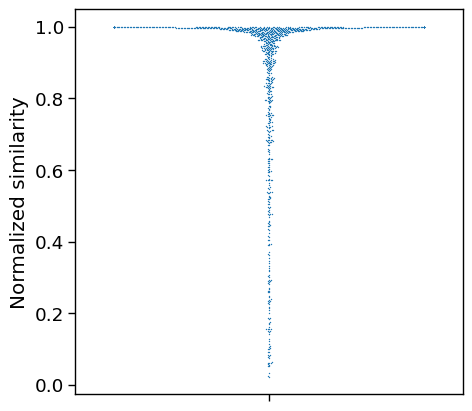

In [27]:
#plot distribution of the similarity percentile score for unnamed sets
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(5,5))
sns.swarmplot(y='true_GO_term_sim_percentile', data=rank_sim_df, size=1)
plt.xlabel('')
plt.ylabel('Normalized similarity')
plt.show()


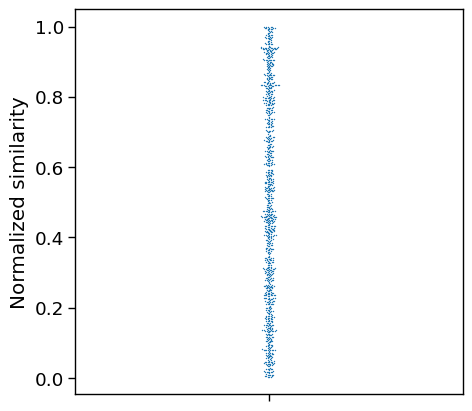

In [28]:
#plot distribution of the similarity percentile score for unnamed sets
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(5,5))
sns.swarmplot(y='random_sim_percentile', data=rank_sim_df, size=1)
plt.xlabel('')
plt.ylabel('Normalized similarity')
plt.show()


In [29]:
# filter out the unnamed sets
rank_sim_df_filter = rank_sim_df.loc[rank_sim_df['gpt_4_default Name'] != 'System of unrelated proteins']
# check anything with score ==0
print(sum(rank_sim_df_filter['gpt_4_default Score'] == 0))

1


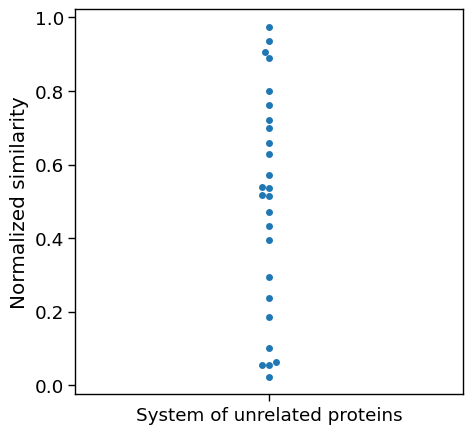

In [25]:
#plot distribution of the similarity percentile score for unnamed sets
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(5,5))
sns.swarmplot(x='gpt_4_default Name', y='true_GO_term_sim_percentile', data=unnamed_sets)
plt.xlabel('')
plt.ylabel('Normalized similarity')
plt.show()


In [6]:
# rank the GO terms by the similarity of LLM name and GO term and pick top 25 and bottom 25 for manual evaluation
rank_sim_df.sort_values(by=['LLM_name_GO_term_sim'], ascending=False, inplace=True)
top = rank_sim_df.head(25)
bottom = rank_sim_df.tail(25)
combine_df = pd.concat([top,bottom], ignore_index=True)


# # add a column to randomly assign number from 1-5, each has the same number of GO terms
# team = [1,2,3,4,5]*10
# import random
# random.seed(2023)
# random.shuffle(team)
# combine_df['team'] = team



combine_df.to_csv('data/GO_term_analysis/best_25_worst_25_similarity_among1000GO.tsv', sep='\t', index=False)


### MF and CC branch similarity

In [6]:
import pandas as pd

for branch in ['CC', 'MF']:
    print(branch)
    all_go = pd.read_csv(f'data/GO_term_analysis/CC_MF_branch/{branch}_go_terms.csv', index_col=0)
    # filtered go terms to size range 3-100 
    # since we picked term size from 3-100, it makes more sense to filter the go term pool to that size range
    min = 3
    max = 100
    filtered_go = all_go[(all_go['Gene_Count'] >= min) & (all_go['Gene_Count'] <= max)]
    max_rank = filtered_go.shape[0]
    
    rank_sim_df = pd.read_csv(f'data/GO_term_analysis/CC_MF_branch/sim_rank_LLM_processed_selected_1000_go_{branch}terms.tsv', sep='\t')
    ## if duplicate
    print(sum(rank_sim_df.duplicated(subset=['GO'])))
    print(sum(rank_sim_df.duplicated(subset=['gpt_4_default Analysis'])))

    #if nan

    print(sum(rank_sim_df['true_GO_term_sim_percentile'].isna()))

    # check how many gpt4 names are 'System of unrelated proteins'
    print(sum(rank_sim_df['gpt_4_default Name'] == 'System of unrelated proteins'))
    print(sum(rank_sim_df['gpt_4_default Score'] == 0))
    # for each of them set the semantic similarity to 0, rank to max number of GO terms, and percentile to 1
    rank_sim_df.loc[rank_sim_df['gpt_4_default Name'] == 'System of unrelated proteins', 'LLM_name_GO_term_sim'] = 0
    rank_sim_df.loc[rank_sim_df['gpt_4_default Name'] == 'System of unrelated proteins', 'sim_rank'] = max_rank
    rank_sim_df.loc[rank_sim_df['gpt_4_default Name'] == 'System of unrelated proteins', 'true_GO_term_sim_percentile'] = 0

    print(sum(rank_sim_df['true_GO_term_sim_percentile']==0))

    rank_sim_df.to_csv(f'data/GO_term_analysis/CC_MF_branch/sim_rank_LLM_processed_selected_1000_go_{branch}terms.tsv', sep='\t', index=False)


CC
0
0
0
17
17
17
MF
0
0
0
8
8
8
